# 모델링





저희 팀은 모델링 파트를 시계열 모델과 비시계열 모델로 구분하여 설명하겠습니다.

아래는 각 파트에서 사용한 모델 목록입니다. 

시계열 모델 :  VAR, Prophet / 딥러닝( LSTM, GRU)  
비시계열 모델 : 다중회귀(Multiple Regression), XgBoost, LGBM, RandomForest, Support Vector Regression(SVR)

미리 말씀드리자면, 저희가 최종적으로 사용한 모델은 비시계열 모델 중 XGBoost이며, 이는 가장 아래에 자세하게 서술했습니다. 

저희는 모델링 파트에서 시계열 모델에 관해 먼저 서술한 후, 비시계열 모델에 관해 서술하고, 마지막으로 비시계열 모델 중 최종 모델인 XGBoost에 대해서 서술하겠습니다.

본격적으로 모델링에 들어가기 앞서, 몇 가지 코드를 실행하고 시작하겠습니다.

먼저, 우리의 모델링에 필요한 모듈 및 패키지들을 import 시킵니다.

In [1]:
import os
import math
import random
import numpy as np
import pandas as pd
from functools import partial
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import tensorflow as tf
from keras.models import Sequential
from keras.layers import LSTM, GRU, Dense, Dropout
from keras.callbacks import EarlyStopping
import xgboost as xgb
from xgboost import cv
import lightgbm as lgb
from google.colab import drive

구글 colab을 이용할 것이기 때문에, 드라이브 내의 파일을 불러오기 위한 코드를 실행하고, 우리가 딥러닝에 사용하기로 한 전처리가 완료된 데이터 파일을 불러옵니다

In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


**1. 시계열 모델**

(1) VAR 

VAR 모델은 다변량 시계열 분석에 쓰이는 대표적 모델 중 하나입니다.

하지만, 우리 데이터에는 VAR모델을 사용하기에 치명적인 문제점이 존재하는데, 그것은 test 데이터의 직전의 과거 데이터가 없다는 것입니다. 이로 인해 2018년 데이터를 예측할 때 2017년 데이터의 마지막 부분에서 예측을 시작하게 됩니다. 따라서, VAR모델은 최종 모델로 사용하지 않을 것으로 결정하였습니다. 하지만, 다른 모델과의 비교를 위해서라도, VAR모델을 간단하게나마 구현해봤습니다. 

VAR모델의 경우 간단하게만 봐주시면 감사드리겠습니다.

VAR 모델을 사용하기 위해서는 statsmodel 패키지를 설치하는 과정이 필요하므로 아래의 코드를 실행합니다.

In [ ]:
pip install statsmodel

ERROR: Could not find a version that satisfies the requirement statsmodel (from versions: none)
ERROR: No matching distribution found for statsmodel


이후에, VAR모델을 import 시켜줍니다.

In [ ]:
import statsmodels
from statsmodels.tsa.vector_ar.var_model import VAR

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm



시계열 모델링에서는 우리가 구현한 스테킹 알고리즘을 사용하지 않기 때문에 스테킹 알고리즘 처리되지 않은 PCA를 진행하고 파생변수를 생성한 최종 데이터프레임을 사용합니다.

데이터를 불러온 후 간단하게 전처리를 하겠습니다.


In [3]:
data = pd.read_csv("/content/drive/MyDrive/2021 빅콘테스트_데이터분석분야_퓨처스리그_홍수ZERO_데이터_210803/Full_impulse_PCA_frame.csv", encoding = 'cp949')

In [4]:
data = data.dropna() # NA값을 삭제 
data = data.reset_index(drop = True) # 인덱스 초기화

어떤 data인지 열어보겠습니다.

In [ ]:
data

,홍수사상번호,연,월,일,시간,datetime,유입량,유역평균강수,강우(A지역),강우(B지역),강우(C지역),강우(D지역),수위(E지역),수위(D지역),유역평균강수_충격,강우A지역_충격,강우B지역_충격,강우D지역_충격,수위E지역_충격,수위D지역_충격,6월,7월,8월,9월
0,2,2006,7,26,6,2006-07-26 06:00:00,319.884969,-2.518104,-2.425320,-2.160009,-2.010936,-2.136145,-1.722051,1.017372,0.000419,0.000419,0.000577,0.000249,-0.000083,0.000074,0,1,0,0
1,2,2006,7,26,7,2006-07-26 07:00:00,354.097150,-2.487052,-2.397396,-2.160009,-1.943756,-2.085775,-1.722051,1.008336,0.000605,0.000605,0.000000,0.000249,-0.000083,0.000087,0,1,0,0
2,2,2006,7,26,8,2006-07-26 08:00:00,363.670434,-2.425494,-2.397396,-2.080793,-1.836443,-2.013939,-1.722051,0.999865,0.000771,0.000771,0.000577,0.000332,0.000000,0.000083,0,1,0,0
3,2,2006,7,26,9,2006-07-26 09:00:00,366.284328,-2.344932,-2.364443,-2.041185,-1.686504,-1.963623,-1.722051,0.991961,0.000844,0.000844,0.000577,0.000498,0.000000,0.000080,0,1,0,0
4,2,2006,7,26,10,2006-07-26 10:00:00,381.637086,-2.240905,-2.309360,-1.922360,-1.582714,-1.848617,-1.701829,0.984482,0.000716,0.000716,0.000000,0.000746,0.000000,0.000075,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2516,25,2017,7,18,18,2017-07-18 18:00:00,513.368437,-2.448139,-2.563027,-2.358050,-2.181766,-2.294295,-1.570380,2.162058,-0.001148,-0.001148,-0.001291,0.000000,-0.000166,-0.000082,0,1,0,0
2517,25,2017,7,18,19,2017-07-18 19:00:00,502.846843,-2.611765,-2.695532,-2.358050,-2.181766,-2.294295,-1.600714,2.166235,-0.002814,-0.002814,-0.003405,0.000000,-0.000166,-0.000079,0,1,0,0
2518,25,2017,7,18,20,2017-07-18 20:00:00,491.954804,-2.654857,-2.728658,-2.358050,-2.181766,-2.294295,-1.620937,2.169647,-0.003654,-0.003654,-0.002929,0.000000,-0.000166,-0.000071,0,1,0,0
2519,25,2017,7,18,21,2017-07-18 21:00:00,481.103083,-2.666444,-2.728658,-2.358050,-2.181766,-2.294295,-1.641160,2.173625,-0.003628,-0.003628,-0.000639,0.000000,-0.000166,-0.000059,0,1,0,0


앞으로의 과정에서 연, 월, 일, 시간, datetime 변수는 사용하지 않을 것이므로 데이터에서 제외하겠습니다. 

In [5]:
data = data.drop(["연","월","일","시간","datetime"], axis = 1)

따라서, 이후에 모델링에 사용할 데이터의 대략적인 모습은 다음과 같습니다.

In [ ]:
data.head()

,홍수사상번호,유입량,유역평균강수,강우(A지역),강우(B지역),강우(C지역),강우(D지역),수위(E지역),수위(D지역),유역평균강수_충격,강우A지역_충격,강우B지역_충격,강우D지역_충격,수위E지역_충격,수위D지역_충격,6월,7월,8월,9월
0,2,319.884969,-2.518104,-2.425320,-2.160009,-2.010936,-2.136145,-1.722051,1.017372,0.000419,0.000419,0.000577,0.000249,-0.000083,0.000074,0,1,0,0
1,2,354.097150,-2.487052,-2.397396,-2.160009,-1.943756,-2.085775,-1.722051,1.008336,0.000605,0.000605,0.000000,0.000249,-0.000083,0.000087,0,1,0,0
2,2,363.670434,-2.425494,-2.397396,-2.080793,-1.836443,-2.013939,-1.722051,0.999865,0.000771,0.000771,0.000577,0.000332,0.000000,0.000083,0,1,0,0
3,2,366.284328,-2.344932,-2.364443,-2.041185,-1.686504,-1.963623,-1.722051,0.991961,0.000844,0.000844,0.000577,0.000498,0.000000,0.000080,0,1,0,0
4,2,381.637086,-2.240905,-2.309360,-1.922360,-1.582714,-1.848617,-1.701829,0.984482,0.000716,0.000716,0.000000,0.000746,0.000000,0.000075,0,1,0,0


월 범주형 변수는 VAR 모델에서 사용하지 않을 예정이므로 지워줍니다.

또한, train과 validation 데이터만을 추출하기 위해 2~25번 홍수사상을 추출합니다.

마지막으로, NA가 포함된 행을 지우고, index를 다시 0부터 시작하게 전처리합니다.

In [ ]:
train_val_data = data.drop(["6월","7월","8월","9월"], axis = 1)
train_val_data = train_val_data[train_val_data['홍수사상번호'] < 26] 
train_val_data = train_val_data.dropna() # NA를 제거 
train_val_data = train_val_data.reset_index(drop = True) 

전처리 후 데이터의 모양은 다음과 같습니다.

In [ ]:
train_val_data

,홍수사상번호,유입량,유역평균강수,강우(A지역),강우(B지역),강우(C지역),강우(D지역),수위(E지역),수위(D지역),유역평균강수_충격,강우A지역_충격,강우B지역_충격,강우D지역_충격,수위E지역_충격,수위D지역_충격
0,2,319.884969,-2.518104,-2.425320,-2.160009,-2.010936,-2.136145,-1.722051,1.017372,0.000419,0.000419,0.000577,0.000249,-0.000083,0.000074
1,2,354.097150,-2.487052,-2.397396,-2.160009,-1.943756,-2.085775,-1.722051,1.008336,0.000605,0.000605,0.000000,0.000249,-0.000083,0.000087
2,2,363.670434,-2.425494,-2.397396,-2.080793,-1.836443,-2.013939,-1.722051,0.999865,0.000771,0.000771,0.000577,0.000332,0.000000,0.000083
3,2,366.284328,-2.344932,-2.364443,-2.041185,-1.686504,-1.963623,-1.722051,0.991961,0.000844,0.000844,0.000577,0.000498,0.000000,0.000080
4,2,381.637086,-2.240905,-2.309360,-1.922360,-1.582714,-1.848617,-1.701829,0.984482,0.000716,0.000716,0.000000,0.000746,0.000000,0.000075
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2516,25,513.368437,-2.448139,-2.563027,-2.358050,-2.181766,-2.294295,-1.570380,2.162058,-0.001148,-0.001148,-0.001291,0.000000,-0.000166,-0.000082
2517,25,502.846843,-2.611765,-2.695532,-2.358050,-2.181766,-2.294295,-1.600714,2.166235,-0.002814,-0.002814,-0.003405,0.000000,-0.000166,-0.000079
2518,25,491.954804,-2.654857,-2.728658,-2.358050,-2.181766,-2.294295,-1.620937,2.169647,-0.003654,-0.003654,-0.002929,0.000000,-0.000166,-0.000071
2519,25,481.103083,-2.666444,-2.728658,-2.358050,-2.181766,-2.294295,-1.641160,2.173625,-0.003628,-0.003628,-0.000639,0.000000,-0.000166,-0.000059


VAR 모델을 사용하기 위해서는 차분값을 input으로 넣어주어야 하므로 차분을 수행합니다. 

이 때, 홍수사상번호는 범주형 변수로 차분하면 안되므로 제외하고, 차분 후 합쳐줍니다. 

In [ ]:
fix_col = train_val_data['홍수사상번호'] # 범주형 변수니까 제외
other_cols = train_val_data.drop('홍수사상번호', axis = 1) # 수치형 변수들과 y값 추출
diff_other_cols = other_cols.diff(1) # 수치형 변수들과 y값을 1차 차분
diff_train_val_data = pd.concat([fix_col, diff_other_cols], axis = 1) # 데이터 합치기 
diff_train_val_data = diff_train_val_data.dropna() # NA가 발생하면 제외함
diff_train_val_data = diff_train_val_data.reset_index(drop = True) # 인덱스 초기화

차분해서 얻은 데이터는 다음과 같습니다.

In [ ]:
diff_train_val_data

,홍수사상번호,유입량,유역평균강수,강우(A지역),강우(B지역),강우(C지역),강우(D지역),수위(E지역),수위(D지역),유역평균강수_충격,강우A지역_충격,강우B지역_충격,강우D지역_충격,수위E지역_충격,수위D지역_충격
0,2,34.212180,0.031053,0.027923,0.000000,0.067180,0.050370,0.000000,-0.009036,0.000186,0.000186,-5.765009e-04,0.000000,3.713392e-18,0.000013
1,2,9.573285,0.061557,0.000000,0.079216,0.107313,0.071836,0.000000,-0.008470,0.000167,0.000167,5.765009e-04,0.000083,8.311910e-05,-0.000004
2,2,2.613893,0.080562,0.032953,0.039608,0.149939,0.050317,0.000000,-0.007904,0.000072,0.000072,1.301043e-17,0.000166,0.000000e+00,-0.000003
3,2,15.352758,0.104027,0.055083,0.118825,0.103790,0.115006,0.020223,-0.007479,-0.000127,-0.000127,-5.765009e-04,0.000249,0.000000e+00,-0.000005
4,2,19.867407,0.064171,0.038606,0.000000,0.124530,0.043197,0.010111,-0.007207,-0.000293,-0.000293,5.765009e-04,-0.000497,0.000000e+00,0.000005
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2515,25,-9.621006,-0.320334,-0.132505,0.000000,0.000000,0.000000,-0.020223,0.004743,-0.000359,-0.000359,-1.106258e-03,0.000000,-8.311910e-05,0.000009
2516,25,-10.521594,-0.163626,-0.132505,0.000000,0.000000,0.000000,-0.030334,0.004177,-0.001666,-0.001666,-2.113759e-03,0.000000,2.005774e-18,0.000003
2517,25,-10.892038,-0.043092,-0.033126,0.000000,0.000000,0.000000,-0.020223,0.003412,-0.000840,-0.000840,4.756758e-04,0.000000,-6.993104e-18,0.000008
2518,25,-10.851721,-0.011587,0.000000,0.000000,0.000000,0.000000,-0.020223,0.003978,0.000026,0.000026,2.289968e-03,0.000000,6.993104e-18,0.000012


이제, validation을 이용해 모델의 성능을 보기 위해 train셋을 다시 train과 validation으로 나눠줍니다.

In [ ]:
diff_train = diff_train_val_data[diff_train_val_data['홍수사상번호'] < 25]
diff_val = diff_train_val_data[diff_train_val_data['홍수사상번호'] == 25]
diff_train = diff_train.drop('홍수사상번호', axis = 1)
diff_val = diff_val.drop('홍수사상번호', axis = 1)
diff_val = diff_val[1:] # 홍수사상번호가 다른데 차분하는 경우가 생기므로 첫행을 지워줌
diff_val = diff_val.reset_index(drop = True)

본격적으로 모델링을 시작합니다.

VAR모델 객체를 생성한 후, fit을 진행합니다.

In [ ]:
model = VAR(endog = diff_train)
model_fit = model.fit()

학습한 모델을 가지고 prediction을 진행합니다.

In [ ]:
pred = model_fit.forecast(model_fit.y, steps = len(diff_val))
yhat = pred[:,0] # 첫 열이 유입량이므로 따로 추출

y_true = diff_val.iloc[:, 0] # 첫 열이 유입량이므로 따로 추출
y_true = y_true.values # 데이터 프레임이 아닌 value로 저장

/usr/local/lib/python3.7/dist-packages/statsmodels/base/wrapper.py:35: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


VAR 모델은 차분을 원래 값으로 돌려놓기 위해 원본 값이 필요한데, test셋에는 이러한 값이 존재하지 않으므로 실제로 test셋의 원래 값을 예측할 수 없다는 치명적인 단점이 있습니다.

따라서, VAR모델은 위와 같이 기록만 해두고, 실제로는 주어진 데이터에 적합하지 않다고 결론을 내리게 되었습니다.

(2) LSTM

LSTM은 Vanilla RNN을 개선한 딥러닝 모델로, Gradient Vanishing 문제를 셀게이트를 이용하여 해결한 모델입니다. 이는 시계열 분석에서 사용하는 대표적인 딥러닝 모델이며, 저희 팀은 Keras와 TensorFlow를 이용하여 LSTM을 구현하였습니다.


하지만, LSTM에는 공모전에서 주어진 데이터를 처리하기 위해서는 치명적인 문제가 있는데, 바로 예측할 시점의 바로 전 시점의 데이터들이 필요하다는 것입니다. 즉, 2018년 7월 1일의 데이터를 예측하기 위해서는 2018년 6월 30일부터 비누적 시계열 교차검증을 위한(이하 WINDOW SIZE로 정의) 기간만큼의 과거 데이터가 필요한데, 본 데이터에는 이러한 과거 데이터가 주어지지 않았고, 댐의 장소가 익명처리 됨으로 인해 그 바로 전 데이터를 직접 구할 수 없었으므로 기존의 LSTM을 쓰는 방법에서 조금 변형이 필요하였습니다. 따라서, 저희 팀은 다음과 같은 2가지 방법을 생각했습니다.

(i) 다른 머신러닝 모델로 TEST셋의 앞 부분을 예측 후 그 예측값을 과거 데이터로 해서 LSTM 사용(LSTM 학습에 과거 시점의 y값 사용)

XGBoost와 같은 모델은 과거 데이터를 필요로 하지 않고 바로 predict한 값을 얻을 수 있는 장점이 있습니다. 이를 통해 test셋의 앞 부분을 예측한 후, 그 값들을 가지고 LSTM을 사용하는 방식을 고안했습니다. 하지만, 이는 XGBoost의 예측 성능이 아무리 좋다 하여도 결국 실제 y값과는 차이가 존재하며, 이러한 예측 오차가 계속 쌓여가는 결과를 초래하기 때문에 적절하지 않다는 판단을 내려 실현하지 않았습니다.

(ii) 다른 머신러닝 모델로 TEST셋의 앞 부분을 예측, 그리고 뒷 부분은 LSTM으로 예측(LSTM 학습에 y값 사용하지 않음)

이 방법이 위와 다른 것은 LSTM에서 y값을 사용하지 않고, x값만 사용하기 때문에 TEST셋에서 WINDOW SIZE만큼의 앞 부분은 비워두고 그 이후 시점만 예측을 진행하고, 그 앞 부분은 다른 모델의 예측 값으로 채운다는 것입니다. 즉, 두 모델을 함께 사용하되 각각의 prediction만이 존재할 뿐, 한 모델이 다른 모델의 예측값을 사용하지 않는다는 점에서 차이가 있습니다. 아래 구현한 코드는 이 방법을 사용한 것입니다.



HyperParameter Tuning에는 Bayesian Optimization 사용

Train : 홍수사상번호 2~24

Validation : 홍수사상번호 25

25번을 가지고 Validation RMSE를 다른 모델과 비교한 결과, LSTM이 저희가 고안한 스테킹 알고리즘을 적용한 비시계열 머신러닝 모델에 비해 성능이 꽤 떨어진다고 판단되어 모델학습에 오래걸리는 딥러닝의 특성상 CV를 구현하지는 않았습니다.

또한, 저희 팀은 베이지안 최적화를 이용하기로 했기 때문에, 베이지안 최적화를 import 시키기 위해 필요한 패키지를 다운로드하고, import 시켜줍니다(colab을 사용하기 위해서는 계속 베이지안 최적화를 install하는 것이 필요)

In [6]:
pip install bayesian-optimization

  Created wheel for bayesian-optimization: filename=bayesian_optimization-1.2.0-py3-none-any.whl size=11685 sha256=e3382fddad6902b5e70f794c6703dc14d5da36f810f5d9e8c23f3d781be02dbc
  Stored in directory: /root/.cache/pip/wheels/fd/9b/71/f127d694e02eb40bcf18c7ae9613b88a6be4470f57a8528c5b
Successfully built bayesian-optimization


In [7]:
from bayes_opt import BayesianOptimization

코드의 재현성을 위해서는 시드 고정이 필요하므로 필요한 시드를 모두 고정시킬 것입니다. 
seed_everything 함수는 그 작업을 위한 함수입니다. \
현재는 선언만 해두고, 호출은 아래에서 진행할 예정입니다.

참고로, tensorflow의 완벽한 재현성을 위해서는 GPU가 아닌 CPU에서의 작업이 필요하므로 이 점 주의해주시기 바랍니다. 밑의 결과물은 모두 CPU에서 작업했을 때의 결과물입니다. \
사실, 딥러닝은 GPU에서 훨씬 작업이 빠르고 유용하므로, 완벽하게 똑같은 결과가 나오지 않더라도 편의성에 의해 이를 무시하고 사용하는게 일반적입니다. \
하지만, 공모전에서 필요로 하는 완벽한 재현성을 구현하기 위해 GPU로 코드의 예측 정확도를 확인한 후 최종 결과만 CPU로 실행하였음을 알려드립니다.

In [ ]:
def seed_everything(seed = 1234) : 
  random.seed(seed)
  np.random.seed(seed)
  os.environ["PYTHONHASHSEED"] = str(seed)
  os.environ['TF_DETERMINISTIC_OPS'] = '1'
  tf.random.set_seed(seed)

series_to_supervised_breaking 함수 :

아래의 함수는 LSTM의 학습을 도와주는 함수로, 과거 데이터를 계속 shift해서 학습에 사용할 수 있도록 데이터를 구성한 후 반환하여 return하는 함수입니다.

이를 사용하면, 모델링에서 shift하는 과정 없이 바로 이 함수를 통해 반환된 데이터로 LSTM에서 Input Shape만 재정의하여 모델링에 이용할 수 있습니다.

참고로, 우리 팀은 이러한 과정을 홍수사상이 달라지는 부분에서는 shift하지 않았는데, 그 이유는 그 부분에서는 데이터의 값이 너무 확연히 달라져서 모델 학습에 악영향을 끼친다고 판단했기 때문입니다. 실제로 모델링을 진행하였을 때도 성능이 더 안좋아짐을 확인하였기 때문에, 이를 고려하여 각 홍수사상안에서만 shift하였음을 미리 알려드립니다.

In [ ]:
def series_to_supervised_breaking(data, n_in, n_out, dropnan=True): # the function that help LSTM/GRU
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # 과거 n만큼의 시점을 input으로 사용
    for i in range(n_in, 0, -1):
      if i >= n_in and df.iloc[i - n_in,0] != df.iloc[i,0] :
        continue
      else : 
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # n_out만큼의 시점의 y값을 예측 
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]

    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # NA가 있는 행을 지움
    if dropnan:
        agg.dropna(inplace=True)
    return agg

create_model 함수 : 

LSTM 모델을 만들어내는 함수를 정의

이 함수는 딥러닝 모델 구성에 필요한 파라미터를 인자로 받아서 사용합니다.

input_shape : input Node에 입력할 데이터의 모양

dropout_rate : Dropout Layer에 필요한 인자(얼마나 Dropout할지)

num_dense_layers : 몇 개의 hidden layers를 쌓을 지

num_input_nodes : input 노드의 개수

num_dense_nodes : hideen layer에 들어갈 노드의 개수

In [ ]:
def create_model(input_shape, dropout_rate, num_dense_layers, num_input_nodes, num_dense_nodes) : 

  tf.random.set_seed(1234)
  
  model = Sequential()
  model.add(LSTM(num_input_nodes, input_shape = input_shape))

  for i in range(num_dense_layers) : 
    name = 'layer_dense_{0}'.format(i+1)
    model.add(Dense(num_dense_nodes,
                    activation = 'relu',
                    name = name))
    model.add(Dropout(dropout_rate, name = 'dropout_%d'%(i+1)))
    
  model.add(Dense(1))

  return model


fit_with 함수 : 

create_model 함수를 이용하여 모델을 생성한 후 이를 fit해서 RMSE를 계산하여 반환하는 함수

이는 Bayesian Optimization에 필요한 함수로, RMSE가 아닌 -RMSE를 반환하는 이유는 베이지안 최적화 객채에는 maximize 함수만 존재하기 때문입니다. 우리는 최소의 RMSE를 가지는 모델이 필요하므로 -를 붙여주면 Maximize가 Minimize를 대체할 수 있기 때문에 이러한 방법을 사용합니다.
(이유: 어떤 음수들의 집합에서 가장 큰 값은 절대값이 가장 작기 때문입니다) 

In [ ]:
def fit_with(input_shape, learning_rate, dropout_rate, num_dense_layers, num_input_nodes, num_dense_nodes, batch_size, adam_decay, epochs):

    tf.random.set_seed(1234)
    
    model = create_model(input_shape = input_shape,
                         dropout_rate = dropout_rate,
                         num_dense_layers= int(num_dense_layers),
                         num_input_nodes= int(num_input_nodes),
                         num_dense_nodes= int(num_dense_nodes))
    
    es = EarlyStopping(patience = 10)
    adam = tf.keras.optimizers.Adam(learning_rate = learning_rate, decay = adam_decay)

    model.compile(optimizer = adam, loss = 'mse', metrics = ['mse'])

    blackbox = model.fit(x=train_X,
                        y=train_y,
                        epochs=int(epochs),
                        batch_size=int(batch_size),
                        validation_split=0.2,
                         callbacks = [es],
                         verbose = 0)

    yhat = model.predict(val_X)
    yhat = y_scaler.inverse_transform(yhat)

    mse = mean_squared_error(yhat, val_y[WINDOW_SIZE: ])
    rmse = math.sqrt(mse)

    return -rmse

필요한 모든 함수를 정의하였으니 본격적으로 이 함수들을 활용하여 모델링을 시작합니다(주석 참고)

먼저, 시드를 고정하고 Bayesian Optimization에 사용할 파라미터들의 범위를 정의합니다. 

여기서, 정수를 인자로 받아야하는 파라미터들도 존재하는데, 이는 나중에 int()함수를 이용하여 내림 처리를 해줍니다.

In [ ]:
seed_everything(1234) # 시드를 1234로 고정

# Bayesian Optimization에 사용할 파라미터들의 범위를 사용
pbounds = {'learning_rate' : (1e-6, 1e-2),
           'dropout_rate' : (0.2, 0.5),
           'num_dense_layers' : (1,5),
           'num_input_nodes' : (64, 256),
           'num_dense_nodes' : (32,128),
           'batch_size' : (10,100),
           'adam_decay' : (1e-6, 1e-2),
           'epochs' : (10,300)}

WINDOW SIZE를 정의하고, 딥러닝에 사용하기 위해 데이터를 처리해줍니다.

자세한건 코드마다 주석처리를 해놨으나, 요약하자면 다음과 같습니다.



1.   X와 y변수들을 분리한 후 y는 스케일링(MinMax Scaling)을 진행    (참고: PCA 과정에서 X는 스케일링 처리가 되었으므로 따로 스케일링 처리를 진행하지 않았습니다)
2.   series_to_supervised_breaking 함수를 사용해 변형
3.   train, validation을 모두 input_shape에 맞도록 변형





In [ ]:
# WINDOW_SIZE를 사용 -> 이는 우리가 모델링 과정에서 직접 바꿔줍니다.
# 딥러닝은 학습시간이 굉장히 오래 걸리므로, WINDOW SIZE는 5, 10, 15, 20만을 사용해보았습니다(직접 정의).
# 20이상의 값을 사용하지 않은 것은  각 홍수사상마다 WINDOW SIZE만큼의 데이터의 손실이 생기기 때문에 큰 값을 활용하기 어려웠기 때문입니다.
WINDOW_SIZE = 15

VAL_SIZE = len(data[data['홍수사상번호']==25]) # validation은 홍수사상번호가 25번일때이므로 VAL_SIZE를 그만큼으로 정의
n_features = len(data.columns) - 2 # 홍수사상번호와 과거의 y는 데이터에 넣지 않기 때문에 모델링 과정에서 빼주기위해 2를 빼줌

# 위에서 정의한 seris_to_supervised_breaking 함수를 사용하기 위해 필요한 수
# WINDOW_SIZE에 모델링에 필요한 변수의 개수를 곱한 것
n_obs = WINDOW_SIZE * n_features

# X와 y를 나눠주고, 데이터프레임이 형식이 아닌 값들이 필요하므로 values를 이용해 추출
X_values = data.iloc[:, 2:].values 
y_values = data.iloc[:,1].values

# y를 train과 validation으로 나눔
train_y = y_values[ : -VAL_SIZE]
val_y = y_values[-VAL_SIZE : ]

# y변수는 스케일링 해야하므로 스케일러 객체를 생성
y_scaler = MinMaxScaler() 

# train 데이터의 y값을 스케일링 진행
y_scaled = y_scaler.fit_transform(train_y.reshape(-1,1)) 

# X변수들을 위에서 정의한 series_to_supervised_breaking 함수를 이용해 딥러닝에 용이한 모양으로 변형
X_reframed = series_to_supervised_breaking(X_values, WINDOW_SIZE,1) 

그 모양은 다음과 같습니다.

이는 변수들의 개수만큼 과거 데이터가 shift되어 형성되어 있는 모양입니다.

In [ ]:
X_reframed

,var1(t-14),var2(t-14),var3(t-14),var4(t-14),var5(t-14),var6(t-14),var7(t-14),var8(t-14),var9(t-14),var10(t-14),var11(t-14),var12(t-14),var13(t-14),var14(t-14),var15(t-14),var16(t-14),var17(t-14),var1(t-13),var2(t-13),var3(t-13),var4(t-13),var5(t-13),var6(t-13),var7(t-13),var8(t-13),var9(t-13),var10(t-13),var11(t-13),var12(t-13),var13(t-13),var14(t-13),var15(t-13),var16(t-13),var17(t-13),var1(t-12),var2(t-12),var3(t-12),var4(t-12),var5(t-12),var6(t-12),...,var12(t-2),var13(t-2),var14(t-2),var15(t-2),var16(t-2),var17(t-2),var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var8(t-1),var9(t-1),var10(t-1),var11(t-1),var12(t-1),var13(t-1),var14(t-1),var15(t-1),var16(t-1),var17(t-1),var1(t),var2(t),var3(t),var4(t),var5(t),var6(t),var7(t),var8(t),var9(t),var10(t),var11(t),var12(t),var13(t),var14(t),var15(t),var16(t),var17(t)
14,-2.518104,-2.425320,-2.160009,-2.010936,-2.136145,-1.722051,1.017372,0.000419,0.000419,0.000577,0.000249,-0.000083,0.000074,0.0,1.0,0.0,0.0,-2.487052,-2.397396,-2.160009,-1.943756,-2.085775,-1.722051,1.008336,0.000605,0.000605,0.000000,0.000249,-0.000083,0.000087,0.0,1.0,0.0,0.0,-2.425494,-2.397396,-2.080793,-1.836443,-2.013939,-1.722051,...,0.000000,0.000083,0.0,1.0,0.0,0.0,-1.930882,-2.033009,-1.843144,-0.665440,-1.453015,-1.681606,0.895131,0.000882,0.000882,0.000000,0.000415,0.000000,0.000072,0.0,1.0,0.0,0.0,-1.922582,-2.033009,-1.843144,-0.647358,-1.445788,-1.681606,0.871847,0.000506,0.000506,0.000577,0.000498,0.000000,0.000072,0.0,1.0,0.0,0.0
15,-2.487052,-2.397396,-2.160009,-1.943756,-2.085775,-1.722051,1.008336,0.000605,0.000605,0.000000,0.000249,-0.000083,0.000087,0.0,1.0,0.0,0.0,-2.425494,-2.397396,-2.080793,-1.836443,-2.013939,-1.722051,0.999865,0.000771,0.000771,0.000577,0.000332,0.000000,0.000083,0.0,1.0,0.0,0.0,-2.344932,-2.364443,-2.041185,-1.686504,-1.963623,-1.722051,...,0.000000,0.000072,0.0,1.0,0.0,0.0,-1.922582,-2.033009,-1.843144,-0.647358,-1.445788,-1.681606,0.871847,0.000506,0.000506,0.000577,0.000498,0.000000,0.000072,0.0,1.0,0.0,0.0,-1.913645,-2.033009,-1.843144,-0.638239,-1.431416,-1.681606,0.845584,0.000196,0.000196,0.000000,0.000415,0.000083,0.000082,0.0,1.0,0.0,0.0
16,-2.425494,-2.397396,-2.080793,-1.836443,-2.013939,-1.722051,0.999865,0.000771,0.000771,0.000577,0.000332,0.000000,0.000083,0.0,1.0,0.0,0.0,-2.344932,-2.364443,-2.041185,-1.686504,-1.963623,-1.722051,0.991961,0.000844,0.000844,0.000577,0.000498,0.000000,0.000080,0.0,1.0,0.0,0.0,-2.240905,-2.309360,-1.922360,-1.582714,-1.848617,-1.701829,...,0.000000,0.000072,0.0,1.0,0.0,0.0,-1.913645,-2.033009,-1.843144,-0.638239,-1.431416,-1.681606,0.845584,0.000196,0.000196,0.000000,0.000415,0.000083,0.000082,0.0,1.0,0.0,0.0,-1.908887,-2.033009,-1.843144,-0.629271,-1.431416,-1.681606,0.814835,0.000115,0.000115,0.000000,0.000166,0.000000,0.000102,0.0,1.0,0.0,0.0
17,-2.344932,-2.364443,-2.041185,-1.686504,-1.963623,-1.722051,0.991961,0.000844,0.000844,0.000577,0.000498,0.000000,0.000080,0.0,1.0,0.0,0.0,-2.240905,-2.309360,-1.922360,-1.582714,-1.848617,-1.701829,0.984482,0.000716,0.000716,0.000000,0.000746,0.000000,0.000075,0.0,1.0,0.0,0.0,-2.176733,-2.270754,-1.922360,-1.458183,-1.805420,-1.691717,...,0.000083,0.000082,0.0,1.0,0.0,0.0,-1.908887,-2.033009,-1.843144,-0.629271,-1.431416,-1.681606,0.814835,0.000115,0.000115,0.000000,0.000166,0.000000,0.000102,0.0,1.0,0.0,0.0,-1.907531,-2.033009,-1.843144,-0.629271,-1.431416,-1.681606,0.779684,0.000083,0.000083,0.000000,0.000249,0.000000,0.000123,0.0,1.0,0.0,0.0
18,-2.240905,-2.309360,-1.922360,-1.582714,-1.848617,-1.701829,0.984482,0.000716,0.000716,0.000000,0.000746,0.000000,0.000075,0.0,1.0,0.0,0.0,-2.176733,-2.270754,-1.922360,-1.458183,-1.805420,-1.691717,0.977275,0.000424,0.000424,0.000577,0.000249,0.000000,0.000080,0.0,1.0,0.0,0.0,-2.118964,-2.232043,-1.922360,-1.235744,-1.704679,-1.691717,...,0.000000,0.000102,0.0,1.0,0.0,0.0,-1.907531,-2.033009,-1.843144,-0.629271,-1.431416,-1.681606,0.779684,0.000083,0.000083,0.000000,0.000249,0.000000,0.000123,0.0,1.0,0.0,0.0,-1

이어서, 몇 가지 더 처리해주어 딥러닝 학습에 필요한 모양을 완성시킵니다(주석 참고)

In [ ]:
# 함수로 변형된 X데이터에서 values만을 추출
X_values = X_reframed.values

# X변수들의 경우 train 데이터와 validation 데이터를 한번에 변형했으므로 train과 validation을 나눠준다
train_X = X_values[:-VAL_SIZE, : ]
train_y = y_scaled.copy()

# 이 때, validation의 경우 위에서 언급한 것처럼 앞부분을 제외한 부분부터 예측하므로 WINDOW SIZE만큼을 더해준 부분부터 인덱싱한다
val_X = X_values[-VAL_SIZE + WINDOW_SIZE : , : ] 

# X변수 데이터 중 train과 validation의 예측 부분을 제외한 나머지 부분을 가져오기 위해 인덱싱
train_X = train_X[:, :n_obs]
val_X = val_X[:, :n_obs]

# 최종적으로, 입력에 필요한 X변수의 경우 input shape에 맞도록 reshape를 진행한 후, 이 shape를 input_shape라는 변수로 저장
train_X = train_X.reshape((train_X.shape[0], WINDOW_SIZE, n_features))
val_X = val_X.reshape((val_X.shape[0], WINDOW_SIZE, n_features))
input_shape = (train_X.shape[1], train_X.shape[2])



이제 모양이 완성되었으니, 실제 모델링을 시작합니다.

In [ ]:
# partial 함수를 이용하여 fitting을 도움
fit_with_partial = partial(fit_with, input_shape)

# Bayesian Optimization 객체 생성하고 필요한 인자를 넣어줌. 이 때 시드는 1234로 고정
optimizer = BayesianOptimization(
    f = fit_with_partial,
    pbounds = pbounds, 
    random_state = 1234)

# Byesian Optimization 진행
optimizer.maximize(init_points = 10, n_iter = 20, acq = 'ei', xi = 0.01)

|   iter    |  target   | adam_d... | batch_... | dropou... |  epochs   | learni... | num_de... | num_de... | num_in... |
-------------------------------------------------------------------------------------------------------------------------
|  1        | -639.6    |  0.001916 |  65.99    |  0.3313   |  237.8    |  0.0078   |  2.09     |  58.54    |  218.0    |
|  2        | -501.9    |  0.009581 |  88.83    |  0.3073   |  155.3    |  0.006835 |  3.851    |  67.54    |  171.7    |
|  3        | -507.2    |  0.005031 |  11.24    |  0.4318   |  266.0    |  0.003649 |  3.462    |  39.24    |  134.8    |
|  4        | -594.3    |  0.009331 |  68.62    |  0.3192   |  238.7    |  0.003169 |  3.272    |  115.4    |  147.7    |
|  5        | -441.4    |  0.008022 |  22.94    |  0.4113   |  214.3    |  0.002189 |  4.699    |  74.45    |  238.6    |
|  6        | -483.8    |  0.000599 |  26.59    |  0.2142   |  205.7    |  0.005947 |  3.133    |  36.16    |  171.8    |
|  7        | -556.3    

따라서, 우리가 얻은 가장 최적의 조합과 결과 값은 다음과 같습니다. 

In [ ]:
optimizer.max

{'params': {'adam_decay': 0.005791026798548534,
  'batch_size': 97.60881551590894,
  'dropout_rate': 0.4135853269674805,
  'epochs': 45.358205329565855,
  'learning_rate': 0.00898342326655776,
  'num_dense_layers': 4.343160999580032,
  'num_dense_nodes': 108.83014331162977,
  'num_input_nodes': 208.09222221139387},
 'target': -428.1398252239044}

이 때, RMSE는 다음과 같이 출력됩니다.

In [ ]:
rmse = -optimizer.max['target']
print("LSTM의 RMSE: %.3f"%rmse)

LSTM의 RMSE: 428.140


train이 잘 되었는지 확인하기 위해 loss 그래프를 확인해보고 싶습니다.

따라서, 다시 최적의 파라미터에 대해 학습을 진행한 후 그래프를 확인해보겠습니다.

우선, 최적의 파라미터들을 모두 각 변수에 저장합니다.

In [ ]:
max_adam_decay = optimizer.max['params']['adam_decay']
max_batch_size = int(optimizer.max['params']['batch_size'])
max_dropout_rate = optimizer.max['params']['dropout_rate']
max_epochs = int(optimizer.max['params']['epochs'])
max_learning_rate = optimizer.max['params']['learning_rate']
max_num_dense_layers = int(optimizer.max['params']['num_dense_layers'])
max_num_dense_nodes = int(optimizer.max['params']['num_dense_nodes'])
max_num_input_nodes = int(optimizer.max['params']['num_input_nodes'])

그 후, 모델을 정의하고 다시 모델링을 수행합니다.

In [ ]:
# model 선언
model = create_model(input_shape = input_shape,
                     dropout_rate = max_dropout_rate,
                     num_dense_layers = max_num_dense_layers,
                     num_input_nodes = max_num_input_nodes,
                     num_dense_nodes = max_num_dense_nodes)

es = EarlyStopping(patience = 10)
adam = tf.keras.optimizers.Adam(learning_rate = max_learning_rate, decay = max_adam_decay)

model.compile(optimizer = adam, loss = 'mse', metrics = ['mse'])

blackbox = model.fit(x=train_X,
                    y=train_y,
                    epochs=int(max_epochs),
                    batch_size=int(max_batch_size),
                    validation_split=0.2,
                    callbacks = [es],
                    verbose = 0)

위에서 학습한 모델을 이용해, loss 그래프를 그려봅니다.

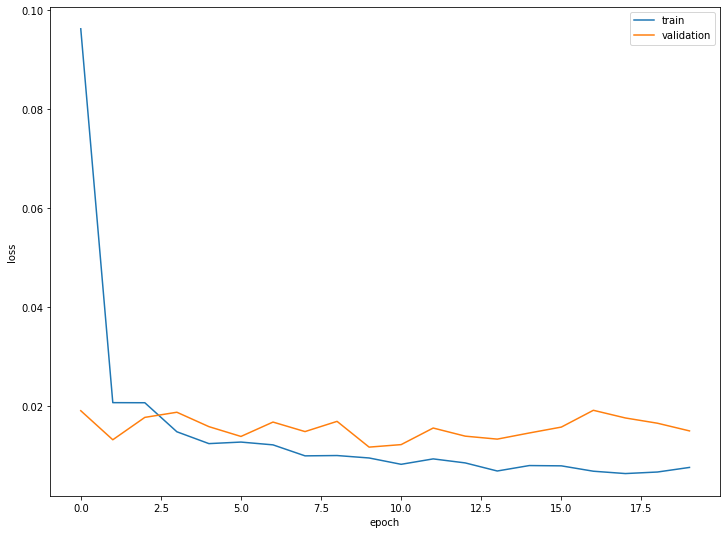

In [ ]:
plt.figure(figsize=(12, 9))
plt.plot(blackbox.history['loss'])
plt.plot(blackbox.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','validation'], loc = 'upper right')
plt.show()

train과정은 잘 수행됐지만, RMSE를 다른 모델과 비교한 결과 이는 이후에 설명할 다른 머신러닝 모델에 비해 현저히 낮은 성능을 보여주는 것으로 판단되므로 LSTM은 최종 TEST셋의 예측을 진행하지 않기로 결정하였습니다.

(3) GRU

GRU는 LSTM을 조금 간소화한 형태로, 이 역시 시계열 모델링에서 많이 쓰이는 모델입니다. GRU의 모든 과정은 LSTM과 같고, 모델을 구성할 때 LSTM이라고 쓰여져 있는 부분을 단순히 GRU로 바꾸고 진행하였습니다. 따라서, 코드에 대한 설명은 주석만 참고해주시기 바랍니다.

우선, Input Layer를 GRU로 바꾼 후 함수를 다시 정의해줍니다.

In [ ]:
def create_model(input_shape, dropout_rate, num_dense_layers, num_input_nodes, num_dense_nodes) : 

  tf.random.set_seed(1234)
  
  model = Sequential()
  model.add(GRU(num_input_nodes, input_shape = input_shape))

  for i in range(num_dense_layers) : 
    name = 'layer_dense_{0}'.format(i+1)
    model.add(Dense(num_dense_nodes,
                    activation = 'relu',
                    name = name))
    model.add(Dropout(dropout_rate, name = 'dropout_%d'%(i+1)))
    
  model.add(Dense(1))

  return model

이후, 위에서 진행한 전처리와 모델링 과정을 똑같이 수행해줍니다.

In [ ]:
# WINDOW_SIZE를 사용 -> 이는 우리가 모델링 과정에서 직접 바꿔줍니다.
# 딥러닝은 학습시간이 굉장히 오래 걸리므로, WINDOW SIZE는 5, 10, 15, 20만을 사용해보았습니다(직접 정의).
# 20이상의 값을 사용하지 않은 것은  각 홍수사상마다 WINDOW SIZE만큼의 데이터의 손실이 생기기 때문에 큰 값을 활용하기 어려웠기 때문입니다.
WINDOW_SIZE = 15

VAL_SIZE = len(data[data['홍수사상번호']==25]) # validation은 홍수사상번호가 25번일때이므로 VAL_SIZE를 그만큼으로 정의
n_features = len(data.columns) - 2 # 홍수사상번호와 과거의 y는 데이터에 넣지 않기 때문에 모델링 과정에서 빼주기위해 2를 빼줌

# 위에서 정의한 seris_to_supervised_breaking 함수를 사용하기 위해 필요한 수
# WINDOW_SIZE에 모델링에 필요한 변수의 개수를 곱한 것
n_obs = WINDOW_SIZE * n_features

# X와 y를 나눠주고, 데이터프레임이 형식이 아닌 값들이 필요하므로 values를 이용해 추출
X_values = data.iloc[:, 2:].values 
y_values = data.iloc[:,1].values

# y를 train과 validation으로 나눔
train_y = y_values[ : -VAL_SIZE]
val_y = y_values[-VAL_SIZE : ]

# y변수는 스케일링 해야하므로 스케일러 객체를 생성
y_scaler = MinMaxScaler() 

# train 데이터의 y값을 스케일링 진행
y_scaled = y_scaler.fit_transform(train_y.reshape(-1,1)) 

# X변수들을 위에서 정의한 series_to_supervised_breaking 함수를 이용해 딥러닝에 용이한 모양으로 변형
X_reframed = series_to_supervised_breaking(X_values, WINDOW_SIZE,1) 

# 함수로 변형된 X데이터에서 values만을 추출
X_values = X_reframed.values

# X변수들의 경우 train 데이터와 validation 데이터를 한번에 변형했으므로 train과 validation을 나눠준다
train_X = X_values[:-VAL_SIZE, : ]
train_y = y_scaled.copy()

# 이 때, validation의 경우 위에서 언급한 것처럼 앞부분을 제외한 부분부터 예측하므로 WINDOW SIZE만큼을 더해준 부분부터 인덱싱한다
val_X = X_values[-VAL_SIZE + WINDOW_SIZE : , : ] 

# X변수 데이터 중 train과 validation의 예측 부분을 제외한 나머지 부분을 가져오기 위해 인덱싱
train_X = train_X[:, :n_obs]
val_X = val_X[:, :n_obs]

# 최종적으로, 입력에 필요한 X변수의 경우 input shape에 맞도록 reshape를 진행한 후, 이 shape를 input_shape라는 변수로 저장
train_X = train_X.reshape((train_X.shape[0], WINDOW_SIZE, n_features))
val_X = val_X.reshape((val_X.shape[0], WINDOW_SIZE, n_features))
input_shape = (train_X.shape[1], train_X.shape[2])

# partial 함수를 이용하여 fitting을 도움
fit_with_partial = partial(fit_with, input_shape)

# Bayesian Optimization 객체 생성하고 필요한 인자를 넣어줌. 이 때 시드는 1234로 고정
optimizer = BayesianOptimization(
    f = fit_with_partial,
    pbounds = pbounds, 
    random_state = 1234)

# Byesian Optimization 진행
optimizer.maximize(init_points = 10, n_iter = 20, acq = 'ei', xi = 0.01)


|   iter    |  target   | adam_d... | batch_... | dropou... |  epochs   | learni... | num_de... | num_de... | num_in... |
-------------------------------------------------------------------------------------------------------------------------
|  1        | -680.6    |  0.001916 |  65.99    |  0.3313   |  237.8    |  0.0078   |  2.09     |  58.54    |  218.0    |
|  2        | -481.9    |  0.009581 |  88.83    |  0.3073   |  155.3    |  0.006835 |  3.851    |  67.54    |  171.7    |
|  3        | -440.2    |  0.005031 |  11.24    |  0.4318   |  266.0    |  0.003649 |  3.462    |  39.24    |  134.8    |
|  4        | -600.8    |  0.009331 |  68.62    |  0.3192   |  238.7    |  0.003169 |  3.272    |  115.4    |  147.7    |
|  5        | -427.3    |  0.008022 |  22.94    |  0.4113   |  214.3    |  0.002189 |  4.699    |  74.45    |  238.6    |
|  6        | -459.0    |  0.000599 |  26.59    |  0.2142   |  205.7    |  0.005947 |  3.133    |  36.16    |  171.8    |
|  7        | -673.3    

이 때, RMSE의 최소값은 다음과 같습니다. 



In [ ]:
rmse = -optimizer.max['target']
print("GRU의 RMSE: %.3f"%rmse)

GRU의 RMSE: 352.230


이 때도 loss 그래프를 그리기 위해 다시 모델을 학습하고 그래프를 그립니다.

In [ ]:
# optimizer 결과 최적의 파라미터 값들을 각 변수에 저장
max_adam_decay = optimizer.max['params']['adam_decay']
max_batch_size = int(optimizer.max['params']['batch_size'])
max_dropout_rate = optimizer.max['params']['dropout_rate']
max_epochs = int(optimizer.max['params']['epochs'])
max_learning_rate = optimizer.max['params']['learning_rate']
max_num_dense_layers = int(optimizer.max['params']['num_dense_layers'])
max_num_dense_nodes = int(optimizer.max['params']['num_dense_nodes'])
max_num_input_nodes = int(optimizer.max['params']['num_input_nodes'])

# model 생성
model = create_model(input_shape = input_shape,
                     dropout_rate = max_dropout_rate,
                     num_dense_layers = max_num_dense_layers,
                     num_input_nodes = max_num_input_nodes,
                     num_dense_nodes = max_num_dense_nodes)


es = EarlyStopping(patience = 10)
adam = tf.keras.optimizers.Adam(learning_rate = max_learning_rate, decay = max_adam_decay)

model.compile(optimizer = adam, loss = 'mse', metrics = ['mse'])

# model training
blackbox = model.fit(x=train_X,
                    y=train_y,
                    epochs=int(max_epochs),
                    batch_size=int(max_batch_size),
                    validation_split=0.2,
                    callbacks = [es],
                    verbose = 0)


Loss 그래프를 그려봅니다.

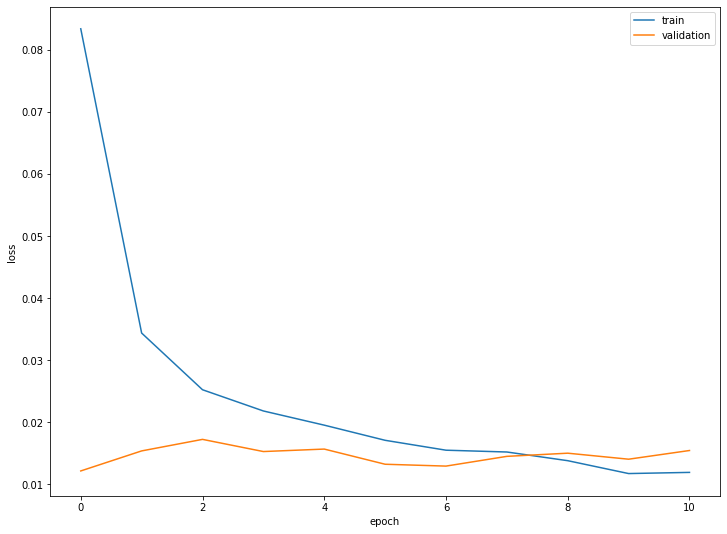

In [ ]:
plt.figure(figsize=(12, 9))
plt.plot(blackbox.history['loss'])
plt.plot(blackbox.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','validation'], loc = 'upper right')
plt.show()

모든 것을 종합한 결과, LSTM과 비슷하게 GRU 역시 최종 모델에는 선정하지 않기로 결정하였습니다.

2. 비시계열 모델 

비시계열 모델에서는 저희가 직접 구현한 "스테킹 알고리즘"이라는 방법을 사용합니다. 그 방법에 대해서는 추가 제출 파일에 자세하게 풀이해놨으니 추가로 제출한 워드 첨부자료를 확인해주시면 감사드리겠습니다.

간단하게 설명하자면, 시계열 자료는 시계열성을 고려하지 않는 비시계열 모델에서 성능이 떨어질 수도 있는 위험성을 가지고 있습니다. 

따라서, 이를 보완하기위해 모델링 과정에서 시계열성을 어느정도 반영하게 변수를 생성하여주는 알고리즘을 개발했습니다.

(1) Multiple Regression

먼저, stacking front와 back 데이터를 불러옵니다.

In [8]:
front_data = pd.read_csv("/content/drive/MyDrive/2021 빅콘테스트_데이터분석분야_퓨처스리그_홍수ZERO_데이터_210803/stacking_front_dataframe.csv", encoding = "cp949")

In [9]:
back_data = pd.read_csv("/content/drive/MyDrive/2021 빅콘테스트_데이터분석분야_퓨처스리그_홍수ZERO_데이터_210803/stacking_back_dataframe.csv", encoding = "cp949")

front data의 모양을 확인하겠습니다.

In [ ]:
front_data

,홍수사상번호,유입량,유역평균강수,강우(A지역),강우(B지역),강우(C지역),강우(D지역),수위(D지역),수위(E지역),유역평균강수_충격,강우A지역_충격,강우B지역_충격,강우D지역_충격,수위D지역_충격,수위E지역_충격,6월,7월,8월,9월
0,2,34.212180,0.003043,0.027923,0.000000,0.067180,0.050370,-0.009036,0.000000,0.000186,0.000186,-5.765009e-04,0.000000,0.000013,3.699840e-18,0,1,0,0
1,2,9.573285,0.030504,0.000000,0.079216,0.107313,0.071836,-0.008470,0.000000,0.000167,0.000167,5.765009e-04,0.000083,-0.000004,8.311910e-05,0,1,0,0
2,2,2.613893,0.019005,0.032953,0.039608,0.149939,0.050317,-0.007904,0.000000,0.000072,0.000072,1.301043e-17,0.000166,-0.000003,0.000000e+00,0,1,0,0
3,2,15.352758,0.023465,0.055083,0.118825,0.103790,0.115006,-0.007479,0.020223,-0.000127,-0.000127,-5.765009e-04,0.000249,-0.000005,0.000000e+00,0,1,0,0
4,2,19.867407,-0.039856,0.038606,0.000000,0.124530,0.043197,-0.007207,0.010111,-0.000293,-0.000293,5.765009e-04,-0.000497,0.000005,0.000000e+00,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2645,26,NaN,0.003723,0.000000,0.000000,-0.008969,0.000000,0.005015,-0.020223,-0.000066,-0.000066,2.739015e-04,0.000000,0.000005,-8.311910e-05,0,1,0,0
2646,26,NaN,-0.000240,0.000000,0.000000,0.000000,0.000000,0.004568,-0.010111,0.001107,0.001107,0.000000e+00,0.000000,-0.000005,-2.005774e-18,0,1,0,0
2647,26,NaN,0.000332,0.000000,0.000000,0.000000,0.000000,0.002896,-0.020223,0.001213,0.001213,0.000000e+00,0.000000,0.000009,8.311910e-05,0,1,0,0
2648,26,NaN,-0.000787,0.000000,0.000000,0.000000,0.000000,0.002896,-0.020223,0.000590,0.000590,0.000000e+00,0.000000,0.000009,-8.311910e-05,0,1,0,0


back data의 모양을 확인하겠습니다

In [ ]:
back_data

,홍수사상번호,유입량,유역평균강수,강우(A지역),강우(B지역),강우(C지역),강우(D지역),수위(D지역),수위(E지역),유역평균강수_충격,강우A지역_충격,강우B지역_충격,강우D지역_충격,수위D지역_충격,수위E지역_충격,6월,7월,8월,9월
0,2,354.097150,-2.487052,-2.397396,-2.160009,-1.943756,-2.085775,1.008336,-1.722051,0.000605,0.000605,0.000000,0.000249,0.000087,-0.000083,0,1,0,0
1,2,363.670434,-2.425494,-2.397396,-2.080793,-1.836443,-2.013939,0.999865,-1.722051,0.000771,0.000771,0.000577,0.000332,0.000083,0.000000,0,1,0,0
2,2,366.284328,-2.344932,-2.364443,-2.041185,-1.686504,-1.963623,0.991961,-1.722051,0.000844,0.000844,0.000577,0.000498,0.000080,0.000000,0,1,0,0
3,2,381.637086,-2.240905,-2.309360,-1.922360,-1.582714,-1.848617,0.984482,-1.701829,0.000716,0.000716,0.000000,0.000746,0.000075,0.000000,0,1,0,0
4,2,401.504492,-2.176733,-2.270754,-1.922360,-1.458183,-1.805420,0.977275,-1.691717,0.000424,0.000424,0.000577,0.000249,0.000080,0.000000,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2645,26,NaN,-2.681881,-2.728658,-2.358050,-2.217995,-2.337439,-0.766655,-1.438932,-0.003191,-0.003191,0.000000,0.000000,-0.000074,-0.000166,0,1,0,0
2646,26,NaN,-2.682534,-2.728658,-2.358050,-2.217995,-2.337439,-0.762087,-1.449043,-0.002084,-0.002084,0.000000,0.000000,-0.000079,-0.000166,0,1,0,0
2647,26,NaN,-2.682855,-2.728658,-2.358050,-2.217995,-2.337439,-0.759191,-1.469266,-0.000871,-0.000871,0.000000,0.000000,-0.000070,-0.000083,0,1,0,0
2648,26,NaN,-2.683963,-2.728658,-2.358050,-2.217995,-2.337439,-0.756295,-1.489489,-0.000281,-0.000281,0.000000,0.000000,-0.000061,-0.000166,0,1,0,0


먼저, 이후 모델링을 쉽게 도와줄 수 있는 함수를 만들고 시작하겠습니다.

concat_data 함수는 인자로 받은 데이터프레임 두개를 열을 기준으로 합쳐주는 함수압나다. 


In [10]:
def concat_data(data1,data2) : 
  concats = pd.concat([data1, data2], axis = 1)
  return concats

저희 팀이 비시계열 모델링에서 사용하는 교차검증(Cross Validation; 이하 CV)은 2\~6번 사상을 학습해서 7번을 예측하고, 2\~14번 사상을 예측해서 15번을 예측하고, 2\~24번을 학습해서 25번을 예측해서 각 RMSE를 평균내는 방식입니다. 

따라서, 아래의 코드는 해당 CV를 수행합니다.

In [ ]:
test_num = [7,15,25]
rmse_list = list() # RMSE를 저장할 리스트 생성
diff_pred_data_List = list() # 차분 유입량의 예측값을 저장하는 리스트 생성 -> 스테킹 알고리즘에 이용
residual_list = list()

for num in test_num : 

  prior_data = front_data[front_data['홍수사상번호'] < num] # 각 시행마다 test number보다 작은 홍수사상번호의 데이터 
  prior_X = prior_data.drop(['홍수사상번호','유입량'], axis = 1) # X와 y를 분리
  prior_y = prior_data['유입량']
  # 2 ~ num까지의 홍수사상번호에 대한 차분값을 예측하기 위해 그 번호들에 대한 X변수를 넣어서 prediction을 수행한다.
  for_predict = front_data[front_data['홍수사상번호'] <= num].drop(['홍수사상번호', '유입량'], axis = 1)

  # LinearRegression 모델 선언
  prior_model = LinearRegression()
  prior_model.fit(prior_X, prior_y) # 차분값 학습
  diff_pred = prior_model.predict(for_predict) # 차분값 예측

  post_data = concat_data(back_data, pd.DataFrame(diff_pred)) # 예측한 차분값을 다시 변수로 저장한 데이터 프레임
  diff_pred_data_List.append(post_data) # 이러한 데이터 프레임이 3개 나오게되는데 각각을 리스트 원소로 저장 -> 다음 단계에 사용

for i in range(3) : 
  post_data = diff_pred_data_List[i] # 각 경우에 필요한 데이터프레임을 불러와 사용할 예정
  num = test_num[i] # 7, 15, 25를 차례로 반복

  # train과 validation을 나눠줌
  train_data = post_data[post_data['홍수사상번호'] < num] 
  val_data = post_data[post_data['홍수사상번호'] == num]

  # X와 y를 나눔
  train_X = train_data.drop(['홍수사상번호','유입량'],axis = 1) 
  train_y = train_data['유입량']
  val_X = val_data.drop(['홍수사상번호','유입량'], axis = 1)
  val_y = val_data['유입량']

  post_model = LinearRegression() # 모델 선언
  post_model.fit(train_X, train_y) # 모델 학습
  pred = post_model.predict(val_X) # 예측

  rmse = math.sqrt(mean_squared_error(pred, val_y)) # RMSE 계산
  rmse_list.append(rmse)
  mean_rmse = np.mean(rmse_list) # RMSE의 평균값 도출

print("RMSE : %.3f"%mean_rmse)

RMSE : 554.906


Multiple Regression의 경우 잔차에 대해 몇 가지 조건을 만족해야 하는데, 그것은 다음과 같습니다. 

(i) 정규성 검정
(ii) 등분산성 가정
(iii) 독립성 가정

하지만, 일반적으로 대부분의 데이터는 이러한 가정을 만족시키기 쉽지않을 뿐더러, 이 Multiple Regression 모델은 저희 팀에서 RMSE를 비교한 결과, 최종 모델로 쓰지 않기로 하였으므로 이러한 과정을 생략하겠습니다.

(2) RandomForest

랜덤포레스트는 일반적으로 정말 많이 쓰이는 트리기반의 모델입니다. 

스테킹 알고리즘을 이용하여 시계열성을 더 고려하게 만든 랜덤포레스트의 진행과정과 결과는 아래와 같습니다.


그 후, train의 X변수와 y변수를 따로 분리합니다.

In [ ]:
train_X = front_data.drop(["홍수사상번호", "유입량"], axis = 1)
train_Y = front_data["유입량"]

딥러닝을 구현하면서 사용했던 Bayesian Optimization을 이번에도 사용할 것이므로 탐색할 파라미터의 범위(최소값, 최대값)를 지정합니다.

In [ ]:
# RandomForest에서 탐색할 하이퍼파라미터의 범위 
pbounds = {"n_estimators" : (100, 8000),
           "max_features" : (1, 16)}

랜덤포레스트, LGBM, XGBoost의 경우 위에서 소개한 교차검증(Cross Validation; 이하 CV)을 더 간편하게 수행하기 위해 도와주는 우리가 만든 클래스를 정의합니다. 

In [15]:
class SkkuFamilyTimeSeriesSplit() : 
  def __init__(self) : 
    self.data = front_data # 이 클래스에서 사용할 데이터는 front_data로 정의

  def get_n_splits(self, groups) : 
    return
  
  def split(self, X, y = None, groups = None) : 
    test_num = [7,15,25] # validation에 사용할 홍수사상번호는 7, 15, 25

    for num in test_num : 
      train_split_data = self.data[self.data['홍수사상번호'] < num] # 각 loop 시행마다 test number 전까지만 train으로 지정
      test_split_data = self.data[self.data['홍수사상번호'] == num] # test 데이터는 딱 그 숫자로 지정 

      # train과 test를 인덱스들을 저장 -> 이는 나중에 cross_val_score 함수에서 이 클래스를 사용하기 위함 
      train_indices = list(train_split_data.index)
      test_indices = list(test_split_data.index)

      yield train_indices, test_indices

이제 랜덤포레스트의 베이지안 최적화를 CV함수를 쓰면서 도와줄 함수를 정의합니다.

이 때, -RMSE를 반환하는데, 이는 베이지안 최적화 과정에서 Maximize를 이용해 RMSE의 최소값을 구해야하기 때문입니다. 자세한 사항은 딥러닝 부분에서도 설명했습니다.

저희가 랜덤포레스트에서 튜닝할 파라미터는 n_estimators, max_features입니다.

In [ ]:
# 베이지만 최적화에 들어갈 모델
def rf_cv(n_estimators, max_features) :

  # 베이지안 최적화는 정수가 아닌 소수점을 가진 실수들로 값들이 배정되므로 정수를 입력으로 받는 파라미터들은 int() 함수를 이용해서 내림 처리
  model=RandomForestRegressor(random_state=1234,
                         max_features = int(max_features),
                        n_estimators = int(n_estimators),
                        criterion = "mse") # mse를 기준으로 cv를 수행
  cv = SkkuFamilyTimeSeriesSplit()
  mse_scores_part = cross_val_score(model, 
                                   train_X,
                                   train_Y, 
                                   cv = cv, 
                                   scoring = 'neg_mean_squared_error')
  rmse_scores_part = np.sqrt(-mse_scores_part)
  rmse_scores = np.mean(rmse_scores_part)
  return -rmse_scores

이제 본격적으로 베이지안 최적화를 시작합니다. 

첫 번째 베이지안 최적화는 차분값을 예측하기 위함입니다. 

In [ ]:
# 베이지안 최적화
first_BO = BayesianOptimization(f = rf_cv,
                          pbounds = pbounds,
                          verbose = 2,
                          random_state = 1234)
first_BO.maximize(init_points=2, n_iter=3, acq='ei', xi=0.01) 

|   iter    |  target   | max_fe... | n_esti... |
-------------------------------------------------
|  1        | -117.9    |  3.873    |  5.015e+0 |
|  2        | -112.1    |  7.566    |  6.304e+0 |
|  3        | -111.9    |  12.7     |  2.253e+0 |
|  4        | -114.0    |  5.147    |  6.435e+0 |
|  5        | -111.4    |  15.37    |  7.02e+03 |
|  6        | -111.5    |  13.76    |  7.02e+03 |
|  7        | -111.4    |  15.31    |  7.028e+0 |
|  8        | -111.4    |  15.88    |  7.021e+0 |
|  9        | -111.4    |  15.31    |  7.006e+0 |
|  10       | -111.4    |  15.55    |  7.041e+0 |


이제 가장 적합하다고 나온 파라미터의 조합으로 다시 모델을 학습한 뒤 차분값이 아닌 실제 유입량을 예측해야 합니다. 

참고로, 이 때 학습은 각 CV마다 다르게 해줘야하는데, 이는 시계열 데이터 특성상 미래의 값을 학습해서 과거를 예측하는 것은 논리적으로 맞지 않기 때문입니다. 

간단한 설명은 여기까지하고, 다음 단계를 진행해보겠습니다.

스테킹 알고리즘의 자세한 사항은 다시 한 번 저희가 첨부한 파일을 확인해주시길 부탁드립니다. 

그러면 이제, 다음 단계를 도와줄 함수를 생성합니다. 

create_model 함수는 파라미터들의 값을 딕셔너리 형태로 받아서 머신러닝 모델(RandomForest) 객체를 만드는 함수입니다.

In [ ]:
def create_model(params) : 
  n_estimators = params['n_estimators']
  max_features = params['max_features']

  model=RandomForestRegressor(random_state=1234,
                         max_features = round(max_features),
                        n_estimators = round(n_estimators),
                        criterion = "mse"
                        )

  return model

먼저, 다시 베이지안 최적화 과정에서 탐색할 파라미터의 범위를 설정합니다. 

In [ ]:
# 탐색할 파라미터 범위 
pbounds = {"n_estimators" : (100, 8000),
           "max_features" : (1, 16)}

첫 번째 베이지안 최적화에서 구한 최적의 조합을 사용하기 위해, 이를 변수에 할당한 후 모델 학습 및 예측을 통해 유입량의 차분값을 예측하고, 이를 변수로 저장합니다. 

이 때, 주의할 점은 n번째 사상을 예측하기 위해서는 2~n-1까지의 홍수사상 데이터만을 가졌다고 가정해야하므로 이를 반영하기 위해 CV에서 각각의 경우마다 다른 데이터로 학습을 한 후 차분값을 예측해야 합니다.

따라서, 우리는 CV에서 3번의 검증을 필요로 하므로 차분값이 각각 다르게 예측된 3개의 데이터프레임을 가지고 아래의 검증을 진행하였습니다.

In [ ]:
best_parameter = first_BO.max["params"] # 첫 번째 베이지안 최적화에서 구한 최적의 조합으로 차분값 예측에 사용할 예정
test_num = [7,15,25]
diff_pred_data_List = list()

# prior 관련 데이터는 차분값 예측을 위함 
for num in test_num : 
  prior_data = front_data[front_data['홍수사상번호'] < num] # 차분값 예측을 위한 데이터 / 테스트 넘버 전까지 학습하고 테스트 넘버를 predict해야 정확한 방법
  prior_X = prior_data.drop(['홍수사상번호','유입량'],axis = 1) # X는 홍수사상번호와 유입량을 제외한 나머지 데이터
  prior_y = prior_data['유입량'] # y는 유입량을 가져온다. 
  for_predict = front_data[front_data['홍수사상번호']<=num].drop(['홍수사상번호','유입량'], axis = 1) # 각 테스트 숫자까지 예측하기 위한 X 데이터

  prior_model = create_model(best_parameter)
  prior_model.fit(prior_X, prior_y)
  diff_pred = prior_model.predict(for_predict) # 2~테스트넘버까지 모두 예측을 함. 이후에 이것을 또다른 변수로 넣을 예정
  
  post_data = concat_data(back_data,pd.DataFrame(diff_pred)) # 위에서 예측한 차분값을 새로운 열로 구성
  diff_pred_data_List.append(post_data) # 이렇게 만들어진 데이터 프레임을 뒤에서 쓰기 위해 리스트에 저장 

이후에, 다시 rf_cv 함수를 선언합니다. 

이번 CV에서는 위에서 선언했던 Class와 cross_val_score를 이용하는 것이 아닌, 직접 train과 validation을 구분하여 RMSE를 직접 산출하는 함수를 구성합니다.

In [ ]:
def rf_cv(n_estimators, max_features) : 

  rmse_list = list()
  parameter = {'n_estimators' : n_estimators,
            'max_features' : max_features }

  for i in range(3) : 
    post_data = diff_pred_data_List[i]
    num = test_num[i]
    train_data = post_data[post_data['홍수사상번호'] < num] # train은 test number 전까지
    val_data = post_data[post_data['홍수사상번호'] == num] # validation은 test number에 해당하는 홍수사상번호

    train_X = train_data.drop(['홍수사상번호','유입량'],axis = 1) # X와 y를 나눔
    train_y = train_data['유입량']
    val_X = val_data.drop(['홍수사상번호','유입량'], axis = 1)
    val_y = val_data['유입량']

    post_model = create_model(parameter) 
    post_model.fit(train_X, train_y)
    pred = post_model.predict(val_X)

    rmse = math.sqrt(mean_squared_error(pred, val_y))
    rmse_list.append(rmse)

  mean_rmse = np.mean(rmse_list)
  return -mean_rmse


지금까지 만든 함수들과 베이지안 최적화 객체를 이용하여 두 번째 베이지안 최적화를 수행합니다. 

In [ ]:
# 베이지안 최적화
second_BO = BayesianOptimization(f = rf_cv,
                          pbounds = pbounds,
                          verbose = 2,
                          random_state = 1234)
second_BO.maximize(init_points=2, n_iter=3, acq='ei', xi=0.01) 

|   iter    |  target   | max_fe... | n_esti... |
-------------------------------------------------
|  1        | -604.9    |  3.873    |  5.015e+0 |
|  2        | -573.6    |  7.566    |  6.304e+0 |
|  3        | -561.2    |  12.7     |  2.253e+0 |
|  4        | -597.4    |  5.147    |  6.435e+0 |
|  5        | -560.2    |  15.37    |  7.02e+03 |
|  6        | -563.5    |  13.76    |  7.02e+03 |
|  7        | -561.2    |  12.73    |  2.253e+0 |
|  8        | -562.5    |  15.88    |  7.021e+0 |
|  9        | -571.0    |  11.28    |  2.254e+0 |
|  10       | -560.2    |  14.53    |  7.021e+0 |


최종 CV를 수행한 최소 RMSE는 다음과 같습니다. 

In [ ]:
rmse = -second_BO.max["target"]
print("스꾸팸 RandomForest CV RMSE : %.3f"%rmse)

스꾸팸 RandomForest CV RMSE : 560.157


최적의 파라미터 조합으로 2~24번을 학습 후 25번을 예측했을 때의 그래프를 그리기 위해 다시 모델을 학습 후 predict를 수행합니다.

In [ ]:
max_n_estimators = int(second_BO.max['params']['n_estimators'])
max_max_features = int(second_BO.max['params']['max_features'])

# create model에 쓰기 위해 파라미터를 딕셔너리로 저장
params = {'n_estimators' : max_n_estimators,
          'max_features' : max_max_features}

model = create_model(params) # 모델 생성

train_data = post_data[post_data['홍수사상번호'] < 25]
val_data = post_data[post_data['홍수사상번호'] == 25]
val_data = val_data.reset_index(drop = True) # 이후에 그래프를 그리기 위해 인덱스 초기화
train_X = train_data.drop(['홍수사상번호', '유입량'], axis = 1)
train_y = train_data['유입량']
val_X = val_data.drop(['홍수사상번호','유입량'], axis = 1)
val_y = val_data['유입량']


model.fit(train_X, train_y)

yhat = model.predict(val_X)

랜덤포레스트 모델의 25번 홍수사상의 yhat과 실제 y의 그래프는 다음과 같이 그려집니다.

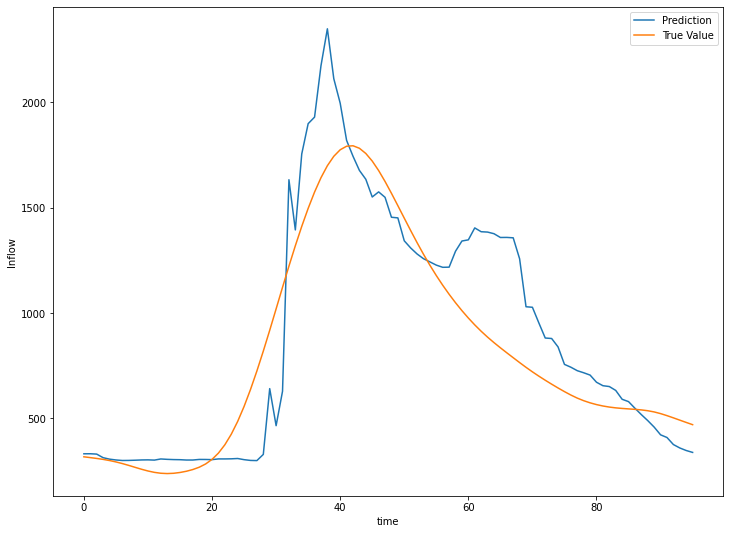

In [ ]:
plt.figure(figsize=(12, 9)) # yhat과 실제 validation y값 간의 차이를 그래프로 그려보겠습니다.
plt.plot(yhat)
plt.plot(val_y)
plt.ylabel('Inflow')
plt.xlabel('time')
plt.legend(['Prediction','True Value'], loc = 'upper right')
plt.show()

(3) LGBM

LGBM과 XGBoost 역시 위의 랜덤포레스트 방식을 수행한 것과 방법이 같으므로 자세한 설명을 생략하겠습니다.  

단지 create_model에서 다른 모델을 선언한다는 점과, 다른 파라미터를 인자로 받는다는 점에서 차이점이 있습니다.

따라서, 반복되는 내용에 대해서는 자세한 설명은 생략하며, 주석으로 풀이하겠습니다.



먼저, train의 X변수와 y변수를 따로 분리합니다.

In [11]:
train_X = front_data.drop(["홍수사상번호", "유입량"], axis = 1)
train_Y = front_data["유입량"]

그 후, 베이지안 최적화 과정에서 탐색할 파라미터들의 범위를 설정합니다. 

In [12]:
# 베이지안 최적화 과정에서 탐색할 파라미터 범위 
pbounds = {"n_estimators" : (100, 8000), 
           "max_depth" : (1, 10),
           "gamma" : (0.01, 5000)}

그 후, LGBM CV과정을 수행해주는 함수를 선언합니다. 
이 때, 위에서 선언한 SkkuFamilyTimeSeriesSplit 클래스를 사용합니다. 

저희가 LGBM 모델에서 튜닝할 파라미터는 n_estimators, max_depth, gamma입니다.

In [13]:
# 베이지만 최적화에 들어갈 모델

def LGBM_cv(n_estimators, max_depth, gamma) :
  # 모델 생성
  model=lgb.LGBMRegressor(random_state=1234,
                        n_estimators = int(n_estimators),
                        max_depth = int(max_depth),
                        gamma = gamma,
                        objective = "regression"
                        )
  cv = SkkuFamilyTimeSeriesSplit() 
  mse_scores_part = cross_val_score(model, 
                                   train_X,
                                   train_Y, 
                                   cv = cv, 
                                   scoring = 'neg_mean_squared_error')
  rmse_scores_part = np.sqrt(-mse_scores_part)
  rmse_scores = np.mean(rmse_scores_part)
  return -rmse_scores # -RMSE를 반환

베이지안 최적화를 수행합니다.

In [16]:
# 베이지안 최적화
first_BO = BayesianOptimization(f = LGBM_cv,
                          pbounds = pbounds,
                          verbose = 2,
                          random_state = 1234)
first_BO.maximize(init_points=10, n_iter=20, acq='ei', xi=0.01) 

|   iter    |  target   |   gamma   | max_depth | n_esti... |
-------------------------------------------------------------
|  1        | -131.1    |  957.6    |  6.599    |  3.558e+0 |
|  2        | -124.9    |  3.927e+0 |  8.02     |  2.253e+0 |
|  3        | -124.9    |  1.382e+0 |  8.217    |  7.669e+0 |
|  4        | -132.3    |  4.38e+03 |  4.22     |  4.058e+0 |
|  5        | -129.2    |  3.417e+0 |  7.414    |  3.025e+0 |
|  6        | -125.0    |  2.806e+0 |  5.528    |  208.8    |
|  7        | -124.9    |  3.864e+0 |  8.944    |  2.983e+0 |
|  8        | -128.9    |  3.077e+0 |  1.678    |  3.014e+0 |
|  9        | -131.1    |  4.666e+0 |  6.862    |  3.238e+0 |
|  10       | -132.6    |  3.944e+0 |  3.852    |  4.588e+0 |
|  11       | -129.2    |  3.905e+0 |  7.317    |  7.364e+0 |
|  12       | -131.1    |  4.584e+0 |  6.552    |  2.408e+0 |
|  13       | -131.1    |  3.889e+0 |  6.519    |  2.942e+0 |
|  14       | -132.3    |  3.076e+0 |  3.7      |  3.023e+0 |
|  15   

LGBM으로 바꾼 create_model 함수입니다.

In [17]:
def create_model(params) : 
  # 파라미터들을 변수에 할당
  n_estimators = params['n_estimators']
  max_depth = params['max_depth']
  gamma = params['gamma']

  # 모델 생성
  model=lgb.LGBMRegressor(random_state=1234,
                        n_estimators = int(n_estimators),
                        max_depth = int(max_depth),
                        gamma = gamma,
                        objective = "regression"
                        )
  return model

랜덤포레스트와 똑같이 첫 번째 베이지안 최적화 과정에서 나온 최적의 파라미터로 학습해서 차분값을 에측합니다.

In [18]:
best_parameter = first_BO.max["params"] # 첫 번째 베이지안 최적화에서 구한 최적의 조합으로 차분값 예측에 사용할 예정
test_num = [7,15,25]
diff_pred_data_List = list()

for num in test_num : 

  prior_data = front_data[front_data['홍수사상번호'] < num] # 차분값 예측을 위한 데이터 / 테스트 넘버 전까지 학습하고 테스트 넘버를 predict해야 정확한 방법
  prior_X = prior_data.drop(['홍수사상번호','유입량'],axis = 1)
  prior_y = prior_data['유입량']
  for_predict = front_data[front_data['홍수사상번호']<=num].drop(['홍수사상번호','유입량'], axis = 1) # 각 테스트 숫자까지 예측하기 위한 데이터

  prior_model = create_model(best_parameter)
  prior_model.fit(prior_X, prior_y)
  diff_pred = prior_model.predict(for_predict) # 2~테스트넘버까지 모두 예측을 함. 이후에 이것을 또다른 변수로 넣을 예정

  post_data = concat_data(back_data,pd.DataFrame(diff_pred)) # 위에서 예측한 차분값을 새로운 열로 구성
  diff_pred_data_List.append(post_data)

랜덤포레스트와 마찬가지로 최종적으로 유입량을 예측해 CV를 수행하는 LGBM_cv 함수를 생성합니다.

In [19]:
def LGBM_cv(n_estimators, max_depth, gamma) : 
  
  rmse_list = list()
  parameter = {'n_estimators' : n_estimators,
            'max_depth' : max_depth,
            'gamma' : gamma}

  for i in range(3) : 
    post_data = diff_pred_data_List[i]
    num = test_num[i]
    train_data = post_data[post_data['홍수사상번호'] < num] # train은 test number 전까지
    val_data = post_data[post_data['홍수사상번호'] == num] # validation은 test number에 해당하는 홍수사상번호

    train_X = train_data.drop(['홍수사상번호','유입량'],axis = 1) # X와 y를 나눔
    train_y = train_data['유입량']
    val_X = val_data.drop(['홍수사상번호','유입량'], axis = 1)
    val_y = val_data['유입량']

    post_model = create_model(parameter) 
    post_model.fit(train_X, train_y)
    pred = post_model.predict(val_X)

    rmse = math.sqrt(mean_squared_error(pred, val_y))
    rmse_list.append(rmse)

  mean_rmse = np.mean(rmse_list)
  return -mean_rmse


마지막으로, 베이지안 최적화를 이용해 모델링을 수행합니다.

In [20]:
# 베이지안 최적화
second_BO = BayesianOptimization(f = LGBM_cv,
                          pbounds = pbounds,
                          verbose = 2,
                          random_state = 1234)
second_BO.maximize(init_points=10, n_iter=20, acq='ei', xi=0.01)

|   iter    |  target   |   gamma   | max_depth | n_esti... |
-------------------------------------------------------------
|  1        | -628.5    |  957.6    |  6.599    |  3.558e+0 |
|  2        | -622.9    |  3.927e+0 |  8.02     |  2.253e+0 |
|  3        | -624.2    |  1.382e+0 |  8.217    |  7.669e+0 |
|  4        | -613.9    |  4.38e+03 |  4.22     |  4.058e+0 |
|  5        | -635.7    |  3.417e+0 |  7.414    |  3.025e+0 |
|  6        | -616.4    |  2.806e+0 |  5.528    |  208.8    |
|  7        | -623.5    |  3.864e+0 |  8.944    |  2.983e+0 |
|  8        | -723.6    |  3.077e+0 |  1.678    |  3.014e+0 |
|  9        | -628.4    |  4.666e+0 |  6.862    |  3.238e+0 |
|  10       | -599.6    |  3.944e+0 |  3.852    |  4.588e+0 |
|  11       | -635.8    |  4.664e+0 |  7.558    |  3.249e+0 |
|  12       | -628.0    |  4.584e+0 |  6.552    |  2.408e+0 |
|  13       | -612.0    |  4.441e+0 |  9.432    |  2.191e+0 |
|  14       | -690.6    |  1.341e+0 |  1.795    |  1.503e+0 |
|  15   

최종 CV를 수행한 최소 RMSE는 다음과 같습니다. 

In [ ]:
rmse = -second_BO.max["target"]
print("스꾸팸 LGBM CV RMSE : %.3f"%rmse)

스꾸팸 LGBM CV RMSE : 598.785


In [22]:
second_BO.max

{'params': {'gamma': 3861.4230081518417,
  'max_depth': 3.837777002287059,
  'n_estimators': 2965.6117526922844},
 'target': -598.7854535889991}

최적의 파라미터 조합으로 2~24번을 학습 후 25번을 예측했을 때의 그래프를 그리기 위해 다시 모델을 학습 후 predict를 수행합니다.

In [ ]:
max_n_estimators = int(second_BO.max['params']['n_estimators'])
max_max_depth = int(second_BO.max['params']['max_depth'])
max_gamma = second_BO.max['params']['max_depth']

params = {'n_estimators' : max_n_estimators,
          'max_depth' : max_max_depth,
          'gamma' : max_gamma}
model = create_model(params)

train_data = post_data[post_data['홍수사상번호'] < 25]
val_data = post_data[post_data['홍수사상번호'] == 25]
val_data = val_data.reset_index(drop = True)
train_X = train_data.drop(['홍수사상번호', '유입량'], axis = 1)
train_y = train_data['유입량']
val_X = val_data.drop(['홍수사상번호','유입량'], axis = 1)
val_y = val_data['유입량']



model.fit(train_X, train_y)

yhat = model.predict(val_X)

LGBM 모델의 25번 홍수사상의 yhat과 실제 y의 그래프는 다음과 같이 그려집니다.

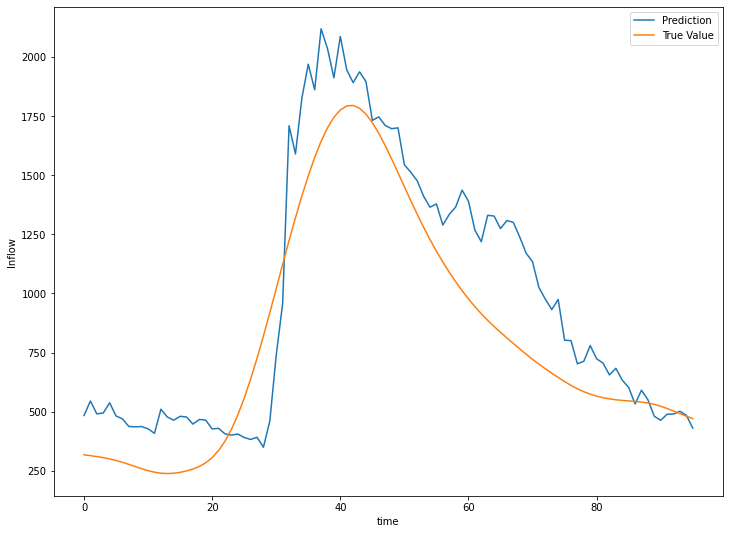

In [ ]:
plt.figure(figsize=(12, 9)) # yhat과 실제 validation y값 간의 차이를 그래프로 그려보겠습니다.
plt.plot(yhat)
plt.plot(val_y)
plt.ylabel('Inflow')
plt.xlabel('time')
plt.legend(['Prediction','True Value'], loc = 'upper right')
plt.show()

(4) XGBoost

XGBoost 역시 랜덤포레스트, LGBM과 똑같은 과정으로 수행됩니다. 

미리 말씀드리자면, XGBoost의 경우 저희의 알고리즘에서 성능이 가장 좋게 나와 저희의 최종 모델로 선정한 모델입니다.



먼저, train의 X변수와 y변수를 따로 분리합니다.

In [23]:
train_X = front_data.drop(["홍수사상번호", "유입량"], axis = 1)
train_Y = front_data["유입량"]

그 후, 베이지안 최적화 과정에서 탐색할 파라미터의 범위를 설정합니다.

In [24]:
# 베이지안 최적화 과정에서 탐색할 파라미터 범위 
pbounds = {"n_estimators" : (100, 8000), 
           "max_depth" : (1, 10),
           "gamma" : (0.01, 5000)}

XGBoost의 CV과정을 수행해주는 함수를 선언합니다. 
이 때, 위에서 선언한 SkkuFamilyTimeSeriesSplit 클래스를 사용합니다. 

저희가 XGBoost모델에서 튜닝할 파라미터는 n_estimators, max_depth, gamma입니다.

In [25]:
# 베이지만 최적화에 들어갈 모델

def XGB_cv(n_estimators, max_depth, gamma) :
  model=xgb.XGBRegressor(random_state=1234,
                        learning_rate = 0.1,
                        min_child_weight = 0.1, 
                        subsample = 0.8, 
                        colsample_bytree =  1,
                        n_estimators = int(n_estimators),
                        max_depth = int(max_depth),
                        gamma = gamma,
                        objective = "reg:squarederror"
                        )
  cv = SkkuFamilyTimeSeriesSplit()
  mse_scores_part = cross_val_score(model, 
                                   train_X,
                                   train_Y, 
                                   cv = cv, 
                                   scoring = 'neg_mean_squared_error')
  rmse_scores_part = np.sqrt(-mse_scores_part)
  rmse_scores = np.mean(rmse_scores_part)
  return -rmse_scores # -RMSE를 반환

베이지안 최적화를 수행합니다.

In [26]:
# 베이지안 최적화
first_BO = BayesianOptimization(f = XGB_cv,
                          pbounds = pbounds,
                          verbose = 2,
                          random_state = 1234)
first_BO.maximize(init_points=10, n_iter=20, acq='ei', xi=0.01) 

|   iter    |  target   |   gamma   | max_depth | n_esti... |
-------------------------------------------------------------
|  1        | -115.0    |  957.6    |  6.599    |  3.558e+0 |
|  2        | -114.5    |  3.927e+0 |  8.02     |  2.253e+0 |
|  3        | -113.9    |  1.382e+0 |  8.217    |  7.669e+0 |
|  4        | -121.4    |  4.38e+03 |  4.22     |  4.058e+0 |
|  5        | -115.7    |  3.417e+0 |  7.414    |  3.025e+0 |
|  6        | -116.2    |  2.806e+0 |  5.528    |  208.8    |
|  7        | -114.2    |  3.864e+0 |  8.944    |  2.983e+0 |
|  8        | -121.8    |  3.077e+0 |  1.678    |  3.014e+0 |
|  9        | -114.9    |  4.666e+0 |  6.862    |  3.238e+0 |
|  10       | -119.3    |  3.944e+0 |  3.852    |  4.588e+0 |
|  11       | -117.1    |  4.664e+0 |  7.558    |  3.249e+0 |
|  12       | -115.4    |  4.584e+0 |  6.552    |  2.408e+0 |
|  13       | -115.4    |  4.441e+0 |  9.432    |  2.191e+0 |
|  14       | -114.8    |  1.341e+0 |  1.795    |  1.503e+0 |
|  15   

XGBoost로 바꾼 create_model 함수입니다.

In [27]:
def create_model(params) : 
  # 파라미터들을 변수에 할당
  n_estimators = params['n_estimators']
  max_depth = params['max_depth']
  gamma = params['gamma']

  # 모델 생성
  model=xgb.XGBRegressor(random_state=1234,
                          learning_rate = 0.1,
                          min_child_weight = 0.1,
                          subsample = 0.8, 
                          colsample_bytree =  1,
                          n_estimators = int(n_estimators),
                          max_depth = int(max_depth),
                          gamma = gamma,
                          objective = "reg:squarederror"
                          )
  return model

첫 번째 베이지안 최적화 과정에서 나온 최적의 파라미터로 학습해서 차분값을 에측합니다.

In [28]:
best_parameter = first_BO.max["params"] # 첫 번째 베이지안 최적화에서 구한 최적의 조합으로 차분값 예측에 사용할 예정
test_num = [7,15,25]
diff_pred_data_List = list()

for num in test_num : 

  prior_data = front_data[front_data['홍수사상번호'] < num] # 차분값 예측을 위한 데이터 / 테스트 넘버 전까지 학습하고 테스트 넘버를 predict해야 정확한 방법
  prior_X = prior_data.drop(['홍수사상번호','유입량'],axis = 1)
  prior_y = prior_data['유입량']
  for_predict = front_data[front_data['홍수사상번호']<=num].drop(['홍수사상번호','유입량'], axis = 1) # 각 테스트 숫자까지 예측하기 위한 데이터

  prior_model = create_model(best_parameter)
  prior_model.fit(prior_X, prior_y)
  diff_pred = prior_model.predict(for_predict) # 2~테스트넘버까지 모두 예측을 함. 이후에 이것을 또다른 변수로 넣을 예정

  post_data = concat_data(back_data,pd.DataFrame(diff_pred)) # 위에서 예측한 차분값을 새로운 열로 구성
  diff_pred_data_List.append(post_data)

최종적으로 유입량을 예측해 CV를 수행하는 XGB_cv 함수를 생성합니다.

In [29]:
def XGB_cv(n_estimators, max_depth, gamma) : 
  rmse_list = list()
  parameter = {'n_estimators' : n_estimators,
               'max_depth' : max_depth,
               'gamma' : gamma}

  for i in range(3) : 
    post_data = diff_pred_data_List[i]
    num = test_num[i]
    train_data = post_data[post_data['홍수사상번호'] < num] # train은 test number 전까지
    val_data = post_data[post_data['홍수사상번호'] == num] # validation은 test number에 해당하는 홍수사상번호

    train_X = train_data.drop(['홍수사상번호','유입량'],axis = 1) # X와 y를 나눔
    train_y = train_data['유입량']
    val_X = val_data.drop(['홍수사상번호','유입량'], axis = 1)
    val_y = val_data['유입량']

    post_model = create_model(parameter) 
    post_model.fit(train_X, train_y)
    pred = post_model.predict(val_X)

    rmse = math.sqrt(mean_squared_error(pred, val_y))
    rmse_list.append(rmse)

  mean_rmse = np.mean(rmse_list)
  return -mean_rmse

마지막으로, 베이지안 최적화를 이용해 모델링을 수행합니다.

In [30]:
# 베이지안 최적화
second_BO = BayesianOptimization(f = XGB_cv,
                          pbounds = pbounds,
                          verbose = 2,
                          random_state = 1234)

second_BO.maximize(init_points=15, n_iter=30, acq='ei', xi=0.01)

|   iter    |  target   |   gamma   | max_depth | n_esti... |
-------------------------------------------------------------
|  1        | -463.6    |  957.6    |  6.599    |  3.558e+0 |
|  2        | -499.5    |  3.927e+0 |  8.02     |  2.253e+0 |
|  3        | -492.7    |  1.382e+0 |  8.217    |  7.669e+0 |
|  4        | -484.7    |  4.38e+03 |  4.22     |  4.058e+0 |
|  5        | -499.0    |  3.417e+0 |  7.414    |  3.025e+0 |
|  6        | -485.3    |  2.806e+0 |  5.528    |  208.8    |
|  7        | -504.4    |  3.864e+0 |  8.944    |  2.983e+0 |
|  8        | -652.1    |  3.077e+0 |  1.678    |  3.014e+0 |
|  9        | -474.8    |  4.666e+0 |  6.862    |  3.238e+0 |
|  10       | -508.7    |  3.944e+0 |  3.852    |  4.588e+0 |
|  11       | -487.3    |  4.346e+0 |  4.926    |  6.437e+0 |
|  12       | -497.4    |  718.8    |  7.338    |  5.666e+0 |
|  13       | -477.8    |  1.094e+0 |  9.324    |  3.593e+0 |
|  14       | -644.3    |  4.547e+0 |  1.538    |  1.556e+0 |
|  15   

In [31]:
second_BO.max

{'params': {'gamma': 1089.2676945706567,
  'max_depth': 6.16468250104038,
  'n_estimators': 3593.7545316357737},
 'target': -459.49823879344893}

최종 CV를 수행한 최소 RMSE는 다음과 같습니다. 

In [ ]:
rmse = -second_BO.max["target"]
print("스꾸팸 XGBoost CV RMSE : %.3f"%rmse)

스꾸팸 XGBoost CV RMSE : 463.608


최적의 파라미터 조합으로 2~24번을 학습 후 25번을 예측했을 때의 그래프를 그리기 위해 다시 모델을 학습 후 predict를 수행합니다.

In [ ]:
max_n_estimators = int(second_BO.max['params']['n_estimators'])
max_max_depth = int(second_BO.max['params']['max_depth'])
max_gamma = second_BO.max['params']['max_depth']

# create model에 쓰기 위해 파라미터를 딕셔너리로 저장
params = {'n_estimators' : max_n_estimators,
          'max_depth' : max_max_depth,
          'gamma' : max_gamma}

model = create_model(params) # 모델 생성

train_data = post_data[post_data['홍수사상번호'] < 25]
val_data = post_data[post_data['홍수사상번호'] == 25]
val_data = val_data.reset_index(drop = True) # 이후에 그래프를 그리기 위해 인덱스 초기화
train_X = train_data.drop(['홍수사상번호', '유입량'], axis = 1)
train_y = train_data['유입량']
val_X = val_data.drop(['홍수사상번호','유입량'], axis = 1)
val_y = val_data['유입량']

model.fit(train_X, train_y)

yhat = model.predict(val_X)

XGBoost 모델의 25번 홍수사상의 yhat과 실제 y의 그래프는 다음과 같이 그려집니다.

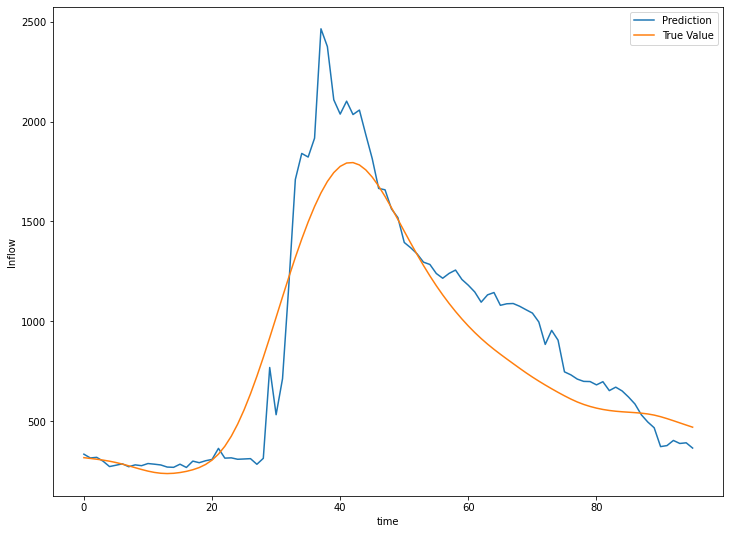

In [ ]:
plt.figure(figsize=(12, 9)) # yhat과 실제 validation y값 간의 차이를 그래프로 그려보겠습니다.
plt.plot(yhat)
plt.plot(val_y)
plt.ylabel('Inflow')
plt.xlabel('time')
plt.legend(['Prediction','True Value'], loc = 'upper right')
plt.show()

XGBoost를 최종 모델로 선택했으므로, 이와 관련해서 SHAP Value와 Feature Importance를 알아보는 과정을 다음과 같이 수행했습니다.

SHAP Value를 볼 것이기 때문에 shap 패키지를 설치한 후 이를 import 시킵니다.

In [ ]:
pip install shap

     |████████████████████████████████| 356 kB 5.2 MB/s 
  Created wheel for shap: filename=shap-0.39.0-cp37-cp37m-linux_x86_64.whl size=491647 sha256=da804812fdcbbc59a5feca6456ac263c4893bd3467788dbb5da3b52e5e62e306
  Stored in directory: /root/.cache/pip/wheels/ca/25/8f/6ae5df62c32651cd719e972e738a8aaa4a87414c4d2b14c9c0
Successfully built shap


In [ ]:
import shap



또한, 한글 폰트를 깨지지 않게 하기위해, 아래의 코드를 실행합니다.

In [ ]:
# 한글 폰트 
%matplotlib inline  
import matplotlib as mpl 
import matplotlib.pyplot as plt 
import matplotlib.font_manager as fm  

!apt-get update -qq
!apt-get install fonts-nanum* -qq
path = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font_name = fm.FontProperties(fname=path, size=10).get_name()
plt.rc('font', family=font_name)

fm._rebuild()
mpl.rcParams['axes.unicode_minus'] = False

Selecting previously unselected package fonts-nanum.
(Reading database ... 148492 files and directories currently installed.)
Preparing to unpack .../fonts-nanum_20170925-1_all.deb ...
Unpacking fonts-nanum (20170925-1) ...
Selecting previously unselected package fonts-nanum-eco.
Preparing to unpack .../fonts-nanum-eco_1.000-6_all.deb ...
Unpacking fonts-nanum-eco (1.000-6) ...
Selecting previously unselected package fonts-nanum-extra.
Preparing to unpack .../fonts-nanum-extra_20170925-1_all.deb ...
Unpacking fonts-nanum-extra (20170925-1) ...
Selecting previously unselected package fonts-nanum-coding.
Preparing to unpack .../fonts-nanum-coding_2.5-1_all.deb ...
Unpacking fonts-nanum-coding (2.5-1) ...
Setting up fonts-nanum-extra (20170925-1) ...
Setting up fonts-nanum (20170925-1) ...
Setting up fonts-nanum-coding (2.5-1) ...
Setting up fonts-nanum-eco (1.000-6) ...
Processing triggers for fontconfig (2.12.6-0ubuntu2) ...


Feature Importance를 얻기 위해 최적의 파라미터로 CV를 다시 진행합니다.

그 과정에서 shap value를 저장해둡니다.

findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans.
findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans.
Glyph 44053 missing from current font.
Glyph 50864 missing from current font.
Glyph 51648 missing from current font.
Glyph 50669 missing from current font.
Glyph 52649 missing from current font.
Glyph 44201 missing from current font.
Glyph 50900 missing from current font.
Glyph 49688 missing from current font.
Glyph 50948 missing from current font.
Glyph 49884 missing from current font.
Glyph 44228 missing from current font.
Glyph 50676 missing from current font.
Glyph 49828 missing from current font.
Glyph 53468 missing from current font.
Glyph 53433 missing from current font.
Glyph 48320 missing from current font.
Glyph 50976 missing from current font.
Glyph 54217 missing from current font.
Glyph 44512 missing from current font.
findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans.
Glyph 4405

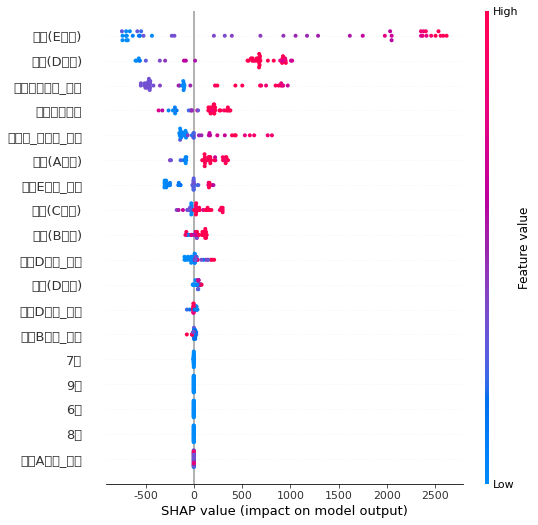

Glyph 44053 missing from current font.
Glyph 50864 missing from current font.
Glyph 51648 missing from current font.
Glyph 50669 missing from current font.
Glyph 52649 missing from current font.
Glyph 44201 missing from current font.
Glyph 50900 missing from current font.
Glyph 49688 missing from current font.
Glyph 50948 missing from current font.
Glyph 50976 missing from current font.
Glyph 54217 missing from current font.
Glyph 44512 missing from current font.
Glyph 49884 missing from current font.
Glyph 44228 missing from current font.
Glyph 50676 missing from current font.
Glyph 49828 missing from current font.
Glyph 53468 missing from current font.
Glyph 53433 missing from current font.
Glyph 48320 missing from current font.
Glyph 44053 missing from current font.
Glyph 50864 missing from current font.
Glyph 51648 missing from current font.
Glyph 50669 missing from current font.
Glyph 52649 missing from current font.
Glyph 44201 missing from current font.
Glyph 50900 missing from 

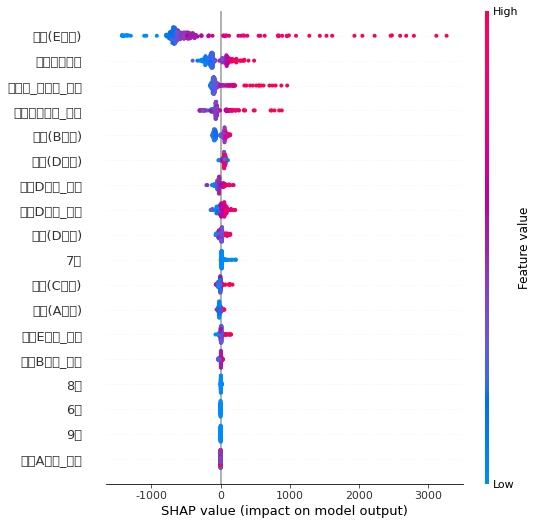

Glyph 44053 missing from current font.
Glyph 50864 missing from current font.
Glyph 51648 missing from current font.
Glyph 50669 missing from current font.
Glyph 52649 missing from current font.
Glyph 44201 missing from current font.
Glyph 50900 missing from current font.
Glyph 49688 missing from current font.
Glyph 50948 missing from current font.
Glyph 50976 missing from current font.
Glyph 54217 missing from current font.
Glyph 44512 missing from current font.
Glyph 49884 missing from current font.
Glyph 44228 missing from current font.
Glyph 50676 missing from current font.
Glyph 49828 missing from current font.
Glyph 53468 missing from current font.
Glyph 53433 missing from current font.
Glyph 48320 missing from current font.
Glyph 44053 missing from current font.
Glyph 50864 missing from current font.
Glyph 51648 missing from current font.
Glyph 50669 missing from current font.
Glyph 52649 missing from current font.
Glyph 44201 missing from current font.
Glyph 50900 missing from 

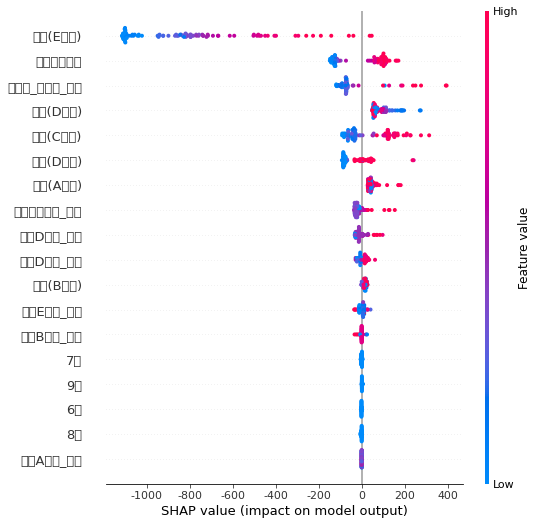

In [ ]:
# feature importance를 얻기 위해 최적의 파라미터로 CV를 다시 진행

best_parameter = second_BO.max["params"] # 두 번째 베이지안 최적화에서 구한 최적의 조합으로 변수 중요도 산출할 것 
test_num = [7,15,25] # CV에서 validation으로 사용될 사상번호 
diff_pred_data_List = list() 
shap_list = list() # SHAP VALUE를 저장할 리스트를 생성
importance_list = list() # tree importance 넣을 리스트 생성


for num in test_num : 

  prior_data = front_data[front_data['홍수사상번호'] < num] # 차분값 예측을 위한 데이터 / 테스트 넘버 전까지 학습하고 테스트 넘버를 predict해야 정확한 방법
  prior_X = prior_data.drop(['홍수사상번호','유입량'],axis = 1)
  prior_y = prior_data['유입량']
  for_predict = front_data[front_data['홍수사상번호']<=num].drop(['홍수사상번호','유입량'], axis = 1) # 각 테스트 숫자까지 예측하기 위한 데이터

  prior_model = create_model(best_parameter)
  prior_model.fit(prior_X, prior_y)
  diff_pred = prior_model.predict(for_predict) # 2~테스트넘버까지 모두 예측을 함. 이후에 이것을 또다른 변수로 넣을 예정

  post_data = concat_data(back_data,pd.DataFrame(diff_pred)) # 위에서 예측한 차분값을 새로운 열로 구성

  diff_pred_data_List.append(post_data)

for i in range(3) : 
    post_data = diff_pred_data_List[i]
    post_data = post_data.rename(columns = {0 : "시계열_스태킹_변수"}) # 그림에서 y차분 예측값이 0이라는 이름으로 나오므로 이름 바꿈 
 

    num = test_num[i]
    train_data = post_data[post_data['홍수사상번호'] < num] # train은 test number 전까지
    val_data = post_data[post_data['홍수사상번호'] == num] # validation은 test number에 해당하는 홍수사상번호

    train_X = train_data.drop(['홍수사상번호','유입량'],axis = 1) # X와 y를 나눔
    train_y = train_data['유입량']
    val_X = val_data.drop(['홍수사상번호','유입량'], axis = 1)
    val_y = val_data['유입량']

    post_model = create_model(best_parameter) 
    post_model.fit(train_X, train_y)
    pred = post_model.predict(val_X)

    # tree importance
    importance_list.append(post_model.feature_importances_)
    

    # SHAP Value
    explainer = shap.TreeExplainer(post_model) # TreeSHAP 사용. 이는 Tree model을 위한 SHAP
    shap_values = explainer.shap_values(val_X)
    shap.summary_plot(shap_values, val_X)
    shap_list.append(shap_values)

아래는 SHAP Value의 평균을 구하기 위한 코드입니다.

In [ ]:
# shap value 평균내기
shap_value_frame = pd.concat([pd.DataFrame(shap_list[0]),
                                pd.DataFrame(shap_list[1]),
                                pd.DataFrame(shap_list[2])])
shap_value_frame.columns = train_X.columns


mean_shap = shap_value_frame.mean(axis = 0)
mean_shap_frame = pd.DataFrame(abs(mean_shap))
mean_shap_frame = mean_shap_frame.sort_values(by = 0) # 정렬
mean_shap_frame # SHAP Value의 평균으로 이루어진 데이터프레임 

,0
강우A지역_충격,0.000000
9월,0.319478
강우B지역_충격,0.582859
6월,1.845135
수위E지역_충격,2.661480
강우(B지역),2.683781
8월,2.804743
강우D지역_충격,5.940325
강우(C지역),7.679410
수위D지역_충격,14.333936


SHAP Value를 시각화 해보면 다음과 같습니다.

findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans.
Glyph 51032 missing from current font.
Glyph 51208 missing from current font.
Glyph 45843 missing from current font.
Glyph 44050 missing from current font.
Glyph 44053 missing from current font.
Glyph 50864 missing from current font.
Glyph 51648 missing from current font.
Glyph 50669 missing from current font.
Glyph 52649 missing from current font.
Glyph 44201 missing from current font.
Glyph 50900 missing from current font.
Glyph 49688 missing from current font.
Glyph 50948 missing from current font.
Glyph 50976 missing from current font.
Glyph 54217 missing from current font.
Glyph 44512 missing from current font.
Glyph 49884 missing from current font.
Glyph 44228 missing from current font.
Glyph 50676 missing from current font.
Glyph 49828 missing from current font.
Glyph 53468 missing from current font.
Glyph 53433 missing from current font.
Glyph 48320 missing from current font.
Glyph 51032 missing 

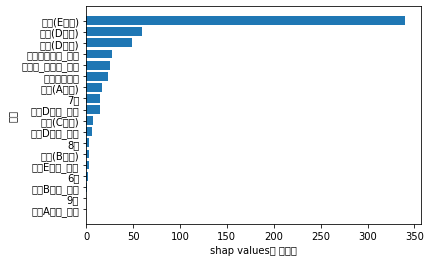

In [ ]:
plt.barh(mean_shap_frame.index, abs(mean_shap_frame.values.reshape(-1, )))
plt.xlabel("shap values의 절댓값")
plt.ylabel("변수")
plt.show()

아래는 Tree Importance를 시각화 한 것입니다.

<BarContainer object of 18 artists>

Glyph 44053 missing from current font.
Glyph 50864 missing from current font.
Glyph 51648 missing from current font.
Glyph 50669 missing from current font.
Glyph 52649 missing from current font.
Glyph 44201 missing from current font.
Glyph 50900 missing from current font.
Glyph 49688 missing from current font.
Glyph 50948 missing from current font.
Glyph 49884 missing from current font.
Glyph 44228 missing from current font.
Glyph 50676 missing from current font.
Glyph 49828 missing from current font.
Glyph 53468 missing from current font.
Glyph 53433 missing from current font.
Glyph 48320 missing from current font.
Glyph 50976 missing from current font.
Glyph 54217 missing from current font.
Glyph 44512 missing from current font.
Glyph 44053 missing from current font.
Glyph 50864 missing from current font.
Glyph 51648 missing from current font.
Glyph 50669 missing from current font.
Glyph 52649 missing from current font.
Glyph 44201 missing from current font.
Glyph 50900 missing from 

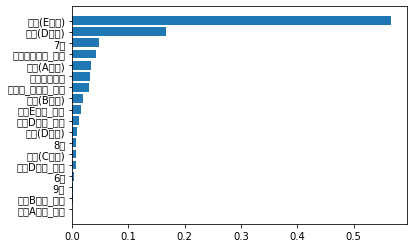

In [ ]:
## tree importance 그래프
impo_frame = pd.DataFrame(importance_list)
impo_frame.columns = train_X.columns
impo_frame = impo_frame.rename(columns = {0 : "댐유입_변화예측"})
mean_importance = pd.DataFrame(impo_frame.mean(axis = 0)) # 열별 평균
mean_importance = mean_importance.sort_values(by = 0)
mean_importance

plt.barh(mean_importance.index, mean_importance[0])

지금부터는 최종모델로 선정한 XGBoost의 홍수사상번호 26번의 예측입니다. 

즉, 평가데이터인 Test 데이터의 유입량을 예측하겠습니다.

우선, 차분값을 예측하기 위한 단계의 train 데이터를 홍수사상번호 2~25로 지정합니다.
우리는 스테킹 알고리즘을 사용하기 위해 train으로 먼저 홍수사상의 차분 유입량을 예측하여 변수로 넣어줄 것이기 때문에, test셋은 나중에 지정하도록 하겠습니다.

In [ ]:
train_front_data = front_data[front_data["홍수사상번호"] != 26]
train_front_data_X = train_front_data.drop(["홍수사상번호", "유입량"], axis = 1)
train_front_data_y = train_front_data["유입량"]

그 후, CV결과 얻은 최적의 파라미터로 새로 2~25번 데이터를 학습합니다.

참고로, 이 때 말하는 최적의 파라미터는 첫 번째 베이지안 최적화(차분값 예측을 위한) 과정에서 나온 최적 파라미터를 사용해야 합니다.

In [ ]:
first_n_estimators = first_BO.max["params"]['n_estimators']
first_max_depth = first_BO.max["params"]['max_depth']
first_gamma = first_BO.max["params"]['gamma']

params = {'n_estimators' : first_n_estimators,
          'max_depth' : first_max_depth,
          'gamma' : first_gamma}

prior_model = create_model(params)

prior_model.fit(train_front_data_X, train_front_data_y)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=966.0458831321648,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=9, min_child_weight=0.1, missing=None, n_estimators=3561,
             n_jobs=1, nthread=None, objective='reg:squarederror',
             random_state=1234, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=0.8, verbosity=1)

차분값을 예측한 결과를 back stacking 데이터와 합친 후, train과 test를 나눕니다.

train : 2~25번 홍수사상

test : 26번 홍수사상

In [ ]:
pred = prior_model.predict(front_data.drop(["홍수사상번호", "유입량"], axis = 1)) # 예측 차분값 -> 스테킹 변수로 활용
complete_back_data = pd.concat([back_data, pd.DataFrame(pred)], axis = 1) # 스테킹 변수를 합칩니다

train = complete_back_data[complete_back_data["홍수사상번호"] != 26]
test = complete_back_data[complete_back_data["홍수사상번호"] == 26]

In [ ]:
train.head()

,홍수사상번호,유입량,유역평균강수,강우(A지역),강우(B지역),강우(C지역),강우(D지역),수위(D지역),수위(E지역),유역평균강수_충격,강우A지역_충격,강우B지역_충격,강우D지역_충격,수위D지역_충격,수위E지역_충격,6월,7월,8월,9월,0
0,2,354.097150,-2.487052,-2.397396,-2.160009,-1.943756,-2.085775,1.008336,-1.722051,0.000605,0.000605,0.000000,0.000249,0.000087,-0.000083,0,1,0,0,17.357269
1,2,363.670434,-2.425494,-2.397396,-2.080793,-1.836443,-2.013939,0.999865,-1.722051,0.000771,0.000771,0.000577,0.000332,0.000083,0.000000,0,1,0,0,5.919397
2,2,366.284328,-2.344932,-2.364443,-2.041185,-1.686504,-1.963623,0.991961,-1.722051,0.000844,0.000844,0.000577,0.000498,0.000080,0.000000,0,1,0,0,0.429056
3,2,381.637086,-2.240905,-2.309360,-1.922360,-1.582714,-1.848617,0.984482,-1.701829,0.000716,0.000716,0.000000,0.000746,0.000075,0.000000,0,1,0,0,23.765942
4,2,401.504492,-2.176733,-2.270754,-1.922360,-1.458183,-1.805420,0.977275,-1.691717,0.000424,0.000424,0.000577,0.000249,0.000080,0.000000,0,1,0,0,7.384568


In [ ]:
test.head()

,홍수사상번호,유입량,유역평균강수,강우(A지역),강우(B지역),강우(C지역),강우(D지역),수위(D지역),수위(E지역),유역평균강수_충격,강우A지역_충격,강우B지역_충격,강우D지역_충격,수위D지역_충격,수위E지역_충격,6월,7월,8월,9월,0
2497,26,NaN,-1.270997,-2.027702,0.018442,-0.984913,-0.690850,-4.632259,-2.652303,0.001987,0.001987,0.002306,0.003978,0.000012,0.000000,0,1,0,0,11.058507
2498,26,NaN,-1.195265,-2.005467,0.137267,-0.933158,-0.654932,-4.632208,-2.652303,0.003249,0.003249,0.003459,0.002904,0.000012,0.000249,0,1,0,0,1.875141
2499,26,NaN,-1.099192,-2.005640,0.295699,-0.841575,-0.633253,-4.632299,-2.642191,0.004138,0.004138,0.008071,0.003407,0.000003,0.000000,0,1,0,0,12.869178
2500,26,NaN,-0.898162,-1.664869,0.335308,-0.292392,-0.367457,-4.632390,-2.490520,0.004472,0.004472,0.013260,0.003652,-0.000003,0.000083,0,1,0,0,79.554535
2501,26,NaN,-0.622598,-1.108800,0.454132,-0.059543,-0.116087,-4.632480,-2.379294,0.002722,0.002722,0.005765,0.001743,-0.000003,0.000000,0,1,0,0,215.343613


train과 test에서 X와 y를 분리해줍니다.

In [ ]:
train_X = train.drop(["홍수사상번호","유입량"], axis = 1)
train_y = train["유입량"]

test_X = test.drop(["홍수사상번호", "유입량"], axis = 1)

CV를 통해 얻은 최적의 파라미터를 가지고 모델링을 진행합니다.

최종모델은 XGBoost입니다.

In [ ]:
second_n_estimators = second_BO.max["params"]['n_estimators']
second_max_depth = second_BO.max["params"]['max_depth']
second_gamma = second_BO.max["params"]['gamma']

params = {'n_estimators' : second_n_estimators,
          'max_depth' : second_max_depth,
          'gamma' : second_gamma}

post_model = create_model(params)

post_model.fit(train_X, train_y)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=957.6053366999575,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=6, min_child_weight=0.1, missing=None, n_estimators=3558,
             n_jobs=1, nthread=None, objective='reg:squarederror',
             random_state=1234, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=0.8, verbosity=1)

이제 test의 X변수로 y값을 predict합니다.

In [ ]:
pred = post_model.predict(test_X)

pred_df = pd.DataFrame({"예측값" : pred}) # predict한 값을 보기 위해 데이터 프레임으로 생성

In [ ]:
pred_df

,예측값
0,241.842743
1,279.691345
2,314.691772
3,643.879150
4,1100.229370
...,...
148,487.752869
149,493.830048
150,478.605835
151,477.728210


보이는 것처럼 우리가 예측한 데이터는 앞 부분을 7개의 데이터를 제외하고 남은 데이터입니다. 이는 스테킹 알고리즘에 의한 것입니다.

이제 앞 부분 7개의 데이터를 예측해 보겠습니다.


먼저, train셋을 위에서 선언한 data로 가져옵니다.

In [ ]:
train_data = data.copy() # train은 위에서 
train_data

,홍수사상번호,유입량,유역평균강수,강우(A지역),강우(B지역),강우(C지역),강우(D지역),수위(E지역),수위(D지역),유역평균강수_충격,강우A지역_충격,강우B지역_충격,강우D지역_충격,수위E지역_충격,수위D지역_충격,6월,7월,8월,9월
0,2,319.884969,-2.518104,-2.425320,-2.160009,-2.010936,-2.136145,-1.722051,1.017372,0.000419,0.000419,0.000577,0.000249,-0.000083,0.000074,0,1,0,0
1,2,354.097150,-2.487052,-2.397396,-2.160009,-1.943756,-2.085775,-1.722051,1.008336,0.000605,0.000605,0.000000,0.000249,-0.000083,0.000087,0,1,0,0
2,2,363.670434,-2.425494,-2.397396,-2.080793,-1.836443,-2.013939,-1.722051,0.999865,0.000771,0.000771,0.000577,0.000332,0.000000,0.000083,0,1,0,0
3,2,366.284328,-2.344932,-2.364443,-2.041185,-1.686504,-1.963623,-1.722051,0.991961,0.000844,0.000844,0.000577,0.000498,0.000000,0.000080,0,1,0,0
4,2,381.637086,-2.240905,-2.309360,-1.922360,-1.582714,-1.848617,-1.701829,0.984482,0.000716,0.000716,0.000000,0.000746,0.000000,0.000075,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2516,25,513.368437,-2.448139,-2.563027,-2.358050,-2.181766,-2.294295,-1.570380,2.162058,-0.001148,-0.001148,-0.001291,0.000000,-0.000166,-0.000082,0,1,0,0
2517,25,502.846843,-2.611765,-2.695532,-2.358050,-2.181766,-2.294295,-1.600714,2.166235,-0.002814,-0.002814,-0.003405,0.000000,-0.000166,-0.000079,0,1,0,0
2518,25,491.954804,-2.654857,-2.728658,-2.358050,-2.181766,-2.294295,-1.620937,2.169647,-0.003654,-0.003654,-0.002929,0.000000,-0.000166,-0.000071,0,1,0,0
2519,25,481.103083,-2.666444,-2.728658,-2.358050,-2.181766,-2.294295,-1.641160,2.173625,-0.003628,-0.003628,-0.000639,0.000000,-0.000166,-0.000059,0,1,0,0


그 후, test셋을 새로 불러오고, . 모양을 보겠습니다.

In [ ]:
test_data = pd.read_csv("/content/drive/MyDrive/Test_impulse_PCA_frame.csv", encoding = 'cp949')
test_data = test_data.drop(["연","월","일","시간","datetime"], axis = 1)
test_data

,홍수사상번호,유입량,유역평균강수,강우(A지역),강우(B지역),강우(C지역),강우(D지역),수위(E지역),수위(D지역),유역평균강수_충격,강우A지역_충격,강우B지역_충격,강우D지역_충격,수위E지역_충격,수위D지역_충격,6월,7월,8월,9월
0,26,NaN,-2.464289,-1.701748,-2.358050,-2.208967,-2.337439,-2.682637,-4.628955,NaN,NaN,NaN,NaN,NaN,NaN,0,1,0,0
1,26,NaN,-2.472915,-2.082785,-2.318442,-1.889835,-2.165077,-2.682637,-4.630236,NaN,NaN,NaN,NaN,NaN,NaN,0,1,0,0
2,26,NaN,-2.341616,-2.221565,-2.160009,-1.757978,-1.820353,-2.692748,-4.631517,NaN,NaN,NaN,NaN,NaN,NaN,0,1,0,0
3,26,NaN,-2.126982,-2.304607,-1.922360,-1.556733,-1.568637,-2.692748,-4.632798,NaN,NaN,NaN,NaN,NaN,NaN,0,1,0,0
4,26,NaN,-1.853566,-2.210745,-1.367845,-1.359102,-1.273402,-2.692748,-4.633088,NaN,NaN,NaN,NaN,0.000000,NaN,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
155,26,NaN,-2.681881,-2.728658,-2.358050,-2.217995,-2.337439,-1.438932,-0.766655,-0.003191,-0.003191,0.0,0.0,-0.000166,-0.000074,0,1,0,0
156,26,NaN,-2.682534,-2.728658,-2.358050,-2.217995,-2.337439,-1.449043,-0.762087,-0.002084,-0.002084,0.0,0.0,-0.000166,-0.000079,0,1,0,0
157,26,NaN,-2.682855,-2.728658,-2.358050,-2.217995,-2.337439,-1.469266,-0.759191,-0.000871,-0.000871,0.0,0.0,-0.000083,-0.000070,0,1,0,0
158,26,NaN,-2.683963,-2.728658,-2.358050,-2.217995,-2.337439,-1.489489,-0.756295,-0.000281,-0.000281,0.0,0.0,-0.000166,-0.000061,0,1,0,0


또한, 충격반응 파생변수는 데이터의 손실을 초래하는데, 이번에 예측해야할 것은 데이터의 손실이 존재하면 안되는 앞 부분이므로 충격반응 파생변수를 train과 test에서 모두 삭제합니다.

In [ ]:
for column in train_data.columns : 
  if "충격" in column :
    train_data = train_data.drop(column, axis = 1)
    test_data = test_data.drop(column, axis = 1)

그 후, 데이터를 열어봅니다.

In [ ]:
train_data

,홍수사상번호,유입량,유역평균강수,강우(A지역),강우(B지역),강우(C지역),강우(D지역),수위(E지역),수위(D지역),6월,7월,8월,9월
0,2,319.884969,-2.518104,-2.425320,-2.160009,-2.010936,-2.136145,-1.722051,1.017372,0,1,0,0
1,2,354.097150,-2.487052,-2.397396,-2.160009,-1.943756,-2.085775,-1.722051,1.008336,0,1,0,0
2,2,363.670434,-2.425494,-2.397396,-2.080793,-1.836443,-2.013939,-1.722051,0.999865,0,1,0,0
3,2,366.284328,-2.344932,-2.364443,-2.041185,-1.686504,-1.963623,-1.722051,0.991961,0,1,0,0
4,2,381.637086,-2.240905,-2.309360,-1.922360,-1.582714,-1.848617,-1.701829,0.984482,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2516,25,513.368437,-2.448139,-2.563027,-2.358050,-2.181766,-2.294295,-1.570380,2.162058,0,1,0,0
2517,25,502.846843,-2.611765,-2.695532,-2.358050,-2.181766,-2.294295,-1.600714,2.166235,0,1,0,0
2518,25,491.954804,-2.654857,-2.728658,-2.358050,-2.181766,-2.294295,-1.620937,2.169647,0,1,0,0
2519,25,481.103083,-2.666444,-2.728658,-2.358050,-2.181766,-2.294295,-1.641160,2.173625,0,1,0,0


In [ ]:
test_data

,홍수사상번호,유입량,유역평균강수,강우(A지역),강우(B지역),강우(C지역),강우(D지역),수위(E지역),수위(D지역),6월,7월,8월,9월
0,26,NaN,-2.464289,-1.701748,-2.358050,-2.208967,-2.337439,-2.682637,-4.628955,0,1,0,0
1,26,NaN,-2.472915,-2.082785,-2.318442,-1.889835,-2.165077,-2.682637,-4.630236,0,1,0,0
2,26,NaN,-2.341616,-2.221565,-2.160009,-1.757978,-1.820353,-2.692748,-4.631517,0,1,0,0
3,26,NaN,-2.126982,-2.304607,-1.922360,-1.556733,-1.568637,-2.692748,-4.632798,0,1,0,0
4,26,NaN,-1.853566,-2.210745,-1.367845,-1.359102,-1.273402,-2.692748,-4.633088,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
155,26,NaN,-2.681881,-2.728658,-2.358050,-2.217995,-2.337439,-1.438932,-0.766655,0,1,0,0
156,26,NaN,-2.682534,-2.728658,-2.358050,-2.217995,-2.337439,-1.449043,-0.762087,0,1,0,0
157,26,NaN,-2.682855,-2.728658,-2.358050,-2.217995,-2.337439,-1.469266,-0.759191,0,1,0,0
158,26,NaN,-2.683963,-2.728658,-2.358050,-2.217995,-2.337439,-1.489489,-0.756295,0,1,0,0


In [ ]:
front_train = train_data[train_data["홍수사상번호"] == 2]
front_train = front_train.iloc[:int(len(front_train) * 0.25), : ]
for i in range(3,26) : 
  front = train_data[train_data["홍수사상번호"] == i ]
  front = front.iloc[:int(len(front) * 0.25), : ]
  front_train = pd.concat([front_train,front], axis = 0)

In [ ]:
front_train = front_train.reset_index(drop = True)
front_train

,홍수사상번호,유입량,유역평균강수,강우(A지역),강우(B지역),강우(C지역),강우(D지역),수위(E지역),수위(D지역),6월,7월,8월,9월
0,2,319.884969,-2.518104,-2.425320,-2.160009,-2.010936,-2.136145,-1.722051,1.017372,0,1,0,0
1,2,354.097150,-2.487052,-2.397396,-2.160009,-1.943756,-2.085775,-1.722051,1.008336,0,1,0,0
2,2,363.670434,-2.425494,-2.397396,-2.080793,-1.836443,-2.013939,-1.722051,0.999865,0,1,0,0
3,2,366.284328,-2.344932,-2.364443,-2.041185,-1.686504,-1.963623,-1.722051,0.991961,0,1,0,0
4,2,381.637086,-2.240905,-2.309360,-1.922360,-1.582714,-1.848617,-1.701829,0.984482,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
617,25,268.477221,-2.376929,-2.525112,-2.318442,-1.095019,-2.164863,-2.156843,1.062057,0,1,0,0
618,25,283.936328,-2.265907,-2.420012,-2.318442,-1.095019,-2.164863,-2.166954,1.065842,0,1,0,0
619,25,305.709577,-2.167870,-2.408948,-2.041185,-1.095019,-2.164863,-2.177066,1.068788,0,1,0,0
620,25,335.564524,-2.120873,-2.353378,-2.041185,-1.095019,-2.164863,-2.187177,1.071441,0,1,0,0


In [ ]:
train_X = front_train.drop(['홍수사상번호','유입량'], axis = 1)
train_y = front_train['유입량']
test_X = test_data.drop(['홍수사상번호','유입량'],axis = 1)

# 베이지안 최적화 과정에서 탐색할 파라미터 범위 
pbounds = {"n_estimators" : (100, 8000), 
           "max_depth" : (1, 10),
           "gamma" : (0.01, 5000)}

# class를 front_train을 이용해서 다시 정의합니다.
class SkkuFamilyTimeSeriesSplit() : 
  def __init__(self) : 
    self.data = front_train # 이 클래스에서 사용할 데이터는 front_data로 정의
  
  def split(self, X, y = None, groups = None) : 
    test_num = [7,15,25] # validation에 사용할 홍수사상번호는 7, 15, 25

    for num in test_num : 
      train_split_data = self.data[self.data['홍수사상번호'] < num] # 각 loop 시행마다 test number 전까지만 train으로 지정
      test_split_data = self.data[self.data['홍수사상번호'] == num] # test 데이터는 딱 그 숫자로 지정 

      # train과 test를 인덱스들을 저장 -> 이는 나중에 cross_val_score 함수에서 이 클래스를 사용하기 위함 
      train_indices = list(train_split_data.index)
      test_indices = list(test_split_data.index)

      yield train_indices, test_indices

# 베이지만 최적화에 들어갈 모델

def XGB_cv(n_estimators, max_depth, gamma) :
  model = 
  model=xgb.XGBRegressor(random_state=1234,
                        learning_rate = 0.1,
                        min_child_weight = 0.1, 
                        subsample = 0.8, 
                        colsample_bytree =  1,
                        n_estimators = int(n_estimators),
                        max_depth = int(max_depth),
                        gamma = gamma,
                        objective = "reg:squarederror"
                        )
  cv = SkkuFamilyTimeSeriesSplit()
  mse_scores_part = cross_val_score(model, 
                                   train_X,
                                   train_y, 
                                   cv = cv, 
                                   scoring = 'neg_mean_squared_error')
  rmse_scores_part = np.sqrt(-mse_scores_part)
  rmse_scores = np.mean(rmse_scores_part)
  return -rmse_scores # -RMSE를 반환

# 베이지안 최적화
BO = BayesianOptimization(f = XGB_cv,
                          pbounds = pbounds,
                          verbose = 2,
                          random_state = 1234)
BO.maximize(init_points=10, n_iter=10, acq='ei', xi=0.01) 



|   iter    |  target   |   gamma   | max_depth | n_esti... |
-------------------------------------------------------------
|  1        | -439.7    |  957.6    |  6.599    |  3.558e+0 |
|  2        | -410.4    |  3.927e+0 |  8.02     |  2.253e+0 |
|  3        | -434.8    |  1.382e+0 |  8.217    |  7.669e+0 |
|  4        | -427.8    |  4.38e+03 |  4.22     |  4.058e+0 |
|  5        | -391.1    |  3.417e+0 |  7.414    |  3.025e+0 |
|  6        | -414.7    |  2.806e+0 |  5.528    |  208.8    |
|  7        | -415.7    |  3.864e+0 |  8.944    |  2.983e+0 |
|  8        | -436.1    |  3.077e+0 |  1.678    |  3.014e+0 |
|  9        | -425.8    |  4.666e+0 |  6.862    |  3.238e+0 |
|  10       | -408.2    |  3.944e+0 |  3.852    |  4.588e+0 |
|  11       | -395.4    |  3.905e+0 |  7.317    |  7.364e+0 |
|  12       | -409.7    |  3.961e+0 |  3.11     |  4.59e+03 |
|  13       | -440.9    |  2.819e+0 |  8.672    |  207.4    |
|  14       | -418.4    |  1.341e+0 |  1.795    |  1.503e+0 |
|  15   

In [ ]:
max_n_estimators = BO.max['params']['n_estimators']
max_max_depth = BO.max['params']['max_depth']
max_gamma = BO.max['params']['gamma']

model=xgb.XGBRegressor(random_state=1234,
                        learning_rate = 0.1,
                        min_child_weight = 0.1, 
                        subsample = 0.8, 
                        colsample_bytree =  1,
                        n_estimators = int(max_n_estimators),
                        max_depth = int(max_max_depth),
                        gamma = max_gamma,
                        objective = "reg:squarederror"
                        )

In [ ]:
model.fit(train_X, train_y)
pred = model.predict(test_X.iloc[:7, : ])

In [ ]:
pred

array([-20.741776,  48.369274,  57.452606,  64.87855 ,  78.37976 ,
       121.076805,  30.710773], dtype=float32)

In [ ]:
pred[0] = pred[1]

26번 홍수사상의 그래프를 그리면 다음과 같습니다.

<function matplotlib.pyplot.show>

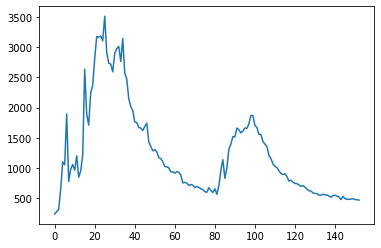

In [ ]:
plt.plot(pred)
plt.show